# Surface Code with Logical Dual Rail Qubits

In [2]:
import stim
import numpy as np
import pymatching

import networkx as nx
import matplotlib.pyplot as plt
from itertools import chain

import scipy.stats as st

import sinter
from typing import List

import pandas as pd
from scipy.optimize import fsolve


import mwpf
from mwpf.sinter_decoders import SinterMWPFDecoder

from mwpf.ref_circuit import *
from mwpf.heralded_dem import *

from scipy.optimize import curve_fit
from numpy import exp, pi, sqrt
import lmfit
from lmfit import Model

from math import log

from decimal import Decimal

import random

import re
import os

In [2]:
cmap = { 0:'orange',
            1:'green',
            2:'crimson',
            3:'deepskyblue', 
            4: "purple", 
            5: "coral", 
            6: "forestgreen",
            7: "firebrick",
            8: "navy",
            9: "blueviolet"}

In [3]:
def decay2(x, a, b, p):
    y = a * (1 - p**x) +b
    return y

In [4]:

def make_func(many_dicts:List, d_list_size, guess):
    intercepts = []

    for sh in range(100):
        random.shuffle(many_dicts)
        x_rand_guess = random.uniform(guess[0][0], guess[0][1])
        y_rand_guess = random.uniform(guess[1][0], guess[1][1])
        new_guess = [x_rand_guess, y_rand_guess]
        #print("new_guess", new_guess)
        for i in range(0, d_list_size):
            dict1 = many_dicts[i % d_list_size]
            dict2 = many_dicts[(i + 1) % d_list_size]

            # print(dict1)
            # print(dict2)
            def func(inputs):
                x = inputs[0]
                y = inputs[1]
                eq1 = dict1['a'] * (1 - dict1['p']**x + dict1['b']) - y
                eq2 = dict2['a'] * (1 - dict2['p']**x + dict2['b']) - y
                return [eq1, eq2]
            intercept = fsolve(func, new_guess)
            # sanity check-- error cannot exceed 1 aka 10^0
            if (intercept[0] < 0) and (intercept[1] < 0):
                intercepts.append(intercept)
    
    return intercepts

Since there is a rare chance that there are zero errors in a sample, math.log will be unable to handle any input lower than the sys float minimum. To handle this, we can have a conditional

In [5]:
import sys 
print(sys.float_info.min)
log(sys.float_info.min)


2.2250738585072014e-308


-708.3964185322641

### find exact threshold

In [6]:
def find_exact_threshold(collected_stats, phys_err_list: Iterable, 
                             err_list_size:int, d_list_size:int, 
                             show_init: bool, 
                             a_list: Iterable, 
                             p_list:Iterable, 
                             guess:List, 
                             show_plots = True,
                             show_fit_report = False,
                             show_threshold_line = True):
    group_func=lambda collected_stats: collected_stats.json_metadata['d']
    grouped_stats = sinter.group_by(collected_stats, key = group_func)

    decay_model = Model(decay2)
    decay_model.set_param_hint('p', min=0.0, max = 1)
    params = decay_model.make_params()

    
    result_list = []
    many_dicts = []


    # maybe include plots with results 
    # logify
    
    #log_phys_err_list = np.log(phys_err_list)
    count = 0
    fig, ax = plt.subplots(1, 1)
    for d in grouped_stats:
        log_grouped_stats_d = []
        log_phys_err_list = []
        gsd_size = len(grouped_stats[d])
        for i in range(gsd_size ):
            
            print("log_err_rate", Decimal(grouped_stats[d][i].errors / grouped_stats[d][i].shots ))
            log_grouped_stats_d.append( Decimal(grouped_stats[d][i].errors / grouped_stats[d][i].shots ))
            log_phys_err_list.append(grouped_stats[d][i].json_metadata['p'])
            
        result = decay_model.fit(log_grouped_stats_d, 
                                 x=np.array(list(log_phys_err_list)), 
                                 a = a_list[count % gsd_size ], 
                                 b = 0, 
                                 p = p_list[count % gsd_size ])
        var_dict = {}
        print(result.fit_report())

        if show_plots == True:
            plt.plot(log_phys_err_list, log_grouped_stats_d, 'o', label = d, color = cmap[count % gsd_size])
            if show_init == True:
                plt.plot(log_phys_err_list, result.init_fit, '--', label='initial fit')
            plt.plot(log_phys_err_list, result.best_fit, '-', label='best fit', color = cmap[count % gsd_size])
            
        print(result.best_values['a'])
        
        result_list.append(result)
        var_dict.update({'a': result.best_values['a']})
        var_dict.update({'b': result.best_values['b']})
        var_dict.update({'p': result.best_values['p']})
        many_dicts.append(var_dict)
        #print(count)
        count += 1

    ax.loglog()
    ax.set_title("Repetition Code Error Rates (Herald and Bitflip Errors)")
    ax.set_xlabel("Phyical Error Rate")
    ax.set_ylabel("Logical Error Rate per Shot")
    ax.grid(which='major')
    ax.grid(which='minor')
    ax.legend()
    plt.show()
    
    intercepts = make_func(many_dicts, d_list_size, [9*10**(-1), 5*10**(-1)])

    print(intercepts)
    
    mean_threshold = np.mean([i[0] for i in intercepts])

    print("threshold", mean_threshold)

    return mean_threshold

### log find exact threshold

In [7]:
def log_find_exact_threshold(collected_stats, phys_err_list: Iterable, 
                             err_list_size:int, d_list_size:int, 
                             show_init: bool, 
                             a_list: Iterable, 
                             p_list:Iterable, 
                             guess:List, 
                             show_plots = True,
                             show_fit_report = False,
                             show_threshold_line = True):
    group_func=lambda collected_stats: collected_stats.json_metadata['d']
    grouped_stats = sinter.group_by(collected_stats, key = group_func)
    


    decay_model = Model(decay2)
    decay_model.set_param_hint('p', min=0.0, max = 1)
    params = decay_model.make_params()

    
    result_list = []
    many_dicts = []


    # maybe include plots with results 
    # logify
    
    #log_phys_err_list = np.log(phys_err_list)
    count = 0
    fig, ax = plt.subplots(1, 1)
    for d in grouped_stats:
        # get size of list per distance
        gsd_size = len(grouped_stats[d])

        log_grouped_stats_d = []
        log_phys_err_list = []
        sub = 0
        for i in range(gsd_size ):
            # print("logical_err_rate", Decimal(grouped_stats[d][i].errors / grouped_stats[d][i].shots ))
            logical_err = Decimal(grouped_stats[d][i].errors / grouped_stats[d][i].shots )
            if logical_err < sys.float_info.min:
                sub += 1
                continue
            log_grouped_stats_d.append( log(logical_err, 10))
            log_phys_err_list.append(log(grouped_stats[d][i].json_metadata['p'], 10))
        
        gsd_size -= sub
            
        result = decay_model.fit(log_grouped_stats_d, 
                                 x=np.array(list(log_phys_err_list)), 
                                 a = a_list[count % gsd_size ], 
                                 b = 0, 
                                 p = p_list[count % gsd_size ])
        var_dict = {}
        if show_fit_report == True:
            print(result.fit_report())

        if show_plots == True:
            plt.plot(log_phys_err_list, log_grouped_stats_d, 'o', label = d, color = cmap[count % gsd_size])
            if show_init == True:
                plt.plot(log_phys_err_list, result.init_fit, '--', label='initial fit')
            plt.plot(log_phys_err_list, result.best_fit, '--', label='best fit', color = cmap[count % gsd_size])
            
        #print(result.best_values['a'])
        
        result_list.append(result)
        var_dict.update({'a': result.best_values['a']})
        var_dict.update({'b': result.best_values['b']})
        var_dict.update({'p': result.best_values['p']})
        many_dicts.append(var_dict)
        #print(count)
        count += 1

    # ax.loglog()
    
    
    
    intercepts = make_func(many_dicts, d_list_size, guess)

    # print(intercepts)
    # print([i[0] for i in intercepts])
    
    mean_threshold_log = np.mean([i[0] for i in intercepts])
    raw_mean_threshold = 10**(mean_threshold_log)

    print(f"\nThe log scaled threshold is {mean_threshold_log}\n The raw threshold is {raw_mean_threshold}")

    ax.set_title("Surface Code Error Rates (Phase and Bitflip Errors)")
    ax.set_xlabel("Logged Phyical Error Rate")
    ax.set_ylabel("Loggged Logical Error Rate per Shot")
    ax.grid(which='major')
    ax.grid(which='minor')
    ax.legend()
    if show_threshold_line == True:
        plt.vlines(mean_threshold_log, ymin = -4, ymax = 0, color = "red", label = f"{10**mean_threshold_log}")
    plt.show()

    return mean_threshold_log

## from the getting started notebook

In [8]:
surface_code_circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=9,
    distance=3,
    after_clifford_depolarization=0.001,
    after_reset_flip_probability=0.001,
    before_measure_flip_probability=0.001,
    before_round_data_depolarization=0.001)

surface_code_circuit.to_file("rotated_memory_z")

print(surface_code_circuit.num_qubits)

surface_code_circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=1,
    distance=5,
    after_clifford_depolarization=0.001,
    after_reset_flip_probability=0.001,
    before_measure_flip_probability=0.001,
    before_round_data_depolarization=0.001)

print(surface_code_circuit.num_qubits)
print(surface_code_circuit)

26
64
QUBIT_COORDS(1, 1) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 1) 3
QUBIT_COORDS(5, 1) 5
QUBIT_COORDS(6, 0) 6
QUBIT_COORDS(7, 1) 7
QUBIT_COORDS(9, 1) 9
QUBIT_COORDS(1, 3) 12
QUBIT_COORDS(2, 2) 13
QUBIT_COORDS(3, 3) 14
QUBIT_COORDS(4, 2) 15
QUBIT_COORDS(5, 3) 16
QUBIT_COORDS(6, 2) 17
QUBIT_COORDS(7, 3) 18
QUBIT_COORDS(8, 2) 19
QUBIT_COORDS(9, 3) 20
QUBIT_COORDS(10, 2) 21
QUBIT_COORDS(0, 4) 22
QUBIT_COORDS(1, 5) 23
QUBIT_COORDS(2, 4) 24
QUBIT_COORDS(3, 5) 25
QUBIT_COORDS(4, 4) 26
QUBIT_COORDS(5, 5) 27
QUBIT_COORDS(6, 4) 28
QUBIT_COORDS(7, 5) 29
QUBIT_COORDS(8, 4) 30
QUBIT_COORDS(9, 5) 31
QUBIT_COORDS(1, 7) 34
QUBIT_COORDS(2, 6) 35
QUBIT_COORDS(3, 7) 36
QUBIT_COORDS(4, 6) 37
QUBIT_COORDS(5, 7) 38
QUBIT_COORDS(6, 6) 39
QUBIT_COORDS(7, 7) 40
QUBIT_COORDS(8, 6) 41
QUBIT_COORDS(9, 7) 42
QUBIT_COORDS(10, 6) 43
QUBIT_COORDS(0, 8) 44
QUBIT_COORDS(1, 9) 45
QUBIT_COORDS(2, 8) 46
QUBIT_COORDS(3, 9) 47
QUBIT_COORDS(4, 8) 48
QUBIT_COORDS(5, 9) 49
QUBIT_COORDS(6, 8) 50
QUBIT_COORDS(7, 9) 51
QUBIT_COO

# plot new normal error spread  

In [9]:
def plot_new_norm_error(collected_stats, erasure_shots = 1e4, pauli_shots = 1e4):
    fig, ax = plt.subplots(1, 1)
    group_func=lambda collected_stats: collected_stats.json_metadata['d']
    grouped_stats = sinter.group_by(collected_stats, key = group_func)

    # stdev = np.sqrt((1/erasure_shots)**2 + (1/pauli_shots)**2)
    
    

    i = 0
    for d in grouped_stats:
        hb = []
        lb = []
        logical_err = []
        phys_err = []
        for task in grouped_stats[d]:
            curr_logical_err = (task.errors) / (task.shots)
            ci = st.norm.interval(0.997, loc=curr_logical_err, scale=1.004e-3)
            hb.append(ci[1])
            lb.append(ci[0])
            logical_err.append(curr_logical_err)
            phys_err.append(task.json_metadata['p'])
        plt.plot(phys_err, logical_err, '-o', label = d, color = cmap[i])
        # plt.plot(phys_err, hb, '--',  color = cmap[i])
        # plt.plot(phys_err, lb, '--',  color= cmap[i])
        plt.fill_between(phys_err, hb, lb, color = cmap[i], alpha=0.2)
        i+=1
    

    ax.loglog()
    ax.set_title("Surface Code Error Rates (Herald and Pauli Errors)")
    ax.set_xlabel("Phyical Error Rate ")
    ax.set_ylabel("Logical Error Rate per Shot")
    ax.grid(which='major')
    ax.grid(which='minor')
    # ax.vlines(4.5e-2, 1e-9, 1, "red")
    ax.legend()

    

# circuit creation func

In [10]:


def make_circuit(distance, p, depol_factor, bf_factor, is_z_or_x, input_file_name):
    surface_code_circuit = stim.Circuit.generated(
        f"surface_code:rotated_memory_{is_z_or_x}",
        rounds=distance*3,
        distance=distance,
        after_clifford_depolarization=p*depol_factor,
        after_reset_flip_probability=p*bf_factor,
        before_measure_flip_probability=p*bf_factor,
        before_round_data_depolarization=p*depol_factor)

    surface_code_circuit.to_file(input_file_name)
    

    
        
def count_erase_qubits(line, erase_qubits):
    erase_qubits.append(int(line[-3:-1]))
    return erase_qubits



def fix_non_erase_detector(line, erase_size, herald_count):
    rec_sect = re.findall(r"rec.+]", line)
    det_sect = re.findall(r"^rec.+]", line)
    digs = re.findall(r"-\d+", line)
    digs = [int(i) for i in digs]
    # print(det_sect)
    # print(rec_sect)
    
    digs_len = len(digs)
    new_digs = []
    if digs_len == 1:
        new_digs.append(digs[0] - erase_size)
    if digs_len == 2:
        new_digs.append(digs[0] - erase_size)
        new_digs.append(digs[1] - (herald_count+1)*(erase_size))
    if digs_len >= 3:
        for i in range(digs_len-1):
            new_digs.append(digs[i] - erase_size)
        new_digs.append(digs[-1] - 2*erase_size)
    new_rec_sect = ""
    # print(new_digs)
    for d in new_digs:
        new_rec_sect = new_rec_sect + f"rec[{d}] "

    new_line = re.sub(r"rec.+]", new_rec_sect, line)

    return new_line
  


def fix_observable(line, erase_size):
    rec_sect = re.findall(r"rec.+]", line)
    obs_sect = re.findall(r"^rec.+]", line)
    digs = re.findall(r"-\d+", line)
    digs = [int(i) for i in digs]
    
    digs_len = len(digs)
    new_digs = []

    for i in range(digs_len):
        new_digs.append(digs[i] - erase_size)
        
    new_rec_sect = ""
    # print(new_digs)
    for d in new_digs:
        new_rec_sect = new_rec_sect + f"rec[{d}] "

    new_line = re.sub(r"rec.+]", new_rec_sect, line)

    return new_line


def add_erasures(out_file, p: float, erase_qubits: list, indent, herald_count):
    if indent == True:
        out_file.write(f'\t')
    out_file.write(f'HERALDED_ERASE({p}) ')
    herald_count += 1
    for i in erase_qubits:
        out_file.write(f'{i} ')
    out_file.write('\n')
    return herald_count


def rewriter(distance:int, 
            error_in: float, 
            depol_factor: float, 
            bf_factor: float,
            is_z_or_x:str,
            input_file:str,
            output_file:str,
            erase_factor = 1):
    
    make_circuit(distance, error_in, depol_factor, bf_factor, is_z_or_x, input_file)

    erase_qubits = []
    herald_count_e = 0
    herald_count_m = 0
    indent = False
    meas_count = 0
    p = error_in * erase_factor

    
    
    
    with open(input_file) as in_file, open(output_file, 'w') as out_file:

        for line in in_file:
            # print("meas_count", meas_count)
            erase_qubit_len = len(erase_qubits)
            num_meas = int((erase_qubit_len - 1)/2)
            num_meas_2 = int((erase_qubit_len + 1)/2)
            # print(num_meas_2)
            # print(herald_count_e, herald_count_m)

            while "DETECTOR(" in line:
                #print("herald count now", herald_count_m)
                new_line = fix_non_erase_detector(line, erase_qubit_len, herald_count_m)
                out_file.write(new_line)
                line = next(in_file)
                
                if "DETECTOR(" not in line:
                    herald_count_m = 0

            while line.startswith("QUBIT"):
                erase_qubits = count_erase_qubits(line, erase_qubits)
                out_file.write(line)
                line = next(in_file)

            if "OBSERVABLE" in line:
                new_line = fix_observable(line, erase_qubit_len)
                out_file.write(new_line)
                break

            
            out_file.write(line)

            if "{" in line:
                indent = True
            elif "}" in line:
                indent = False

            if ("TICK" in line):
                # ADD HERALD
                herald_count_e=add_erasures(out_file, p, erase_qubits, indent, herald_count_e)
                herald_count_m = herald_count_e
                meas_count += herald_count_e*erase_qubit_len
            
            if ('M' in line):
                # ADD HERALD
                herald_count_e=add_erasures(out_file, p, erase_qubits, indent, herald_count_e)
                herald_count_m = herald_count_e
                #print(herald_count_e)
                meas_count += herald_count_m*erase_qubit_len
                # ADD DETECTORS
                if ('MR' in line):
                    # print("meas_count mr", meas_count)
                    meas_count+=num_meas
                    detector_list = range(1, herald_count_e*erase_qubit_len + 1)
                    # print(detector_list )
                    # print("herald count", herald_count_e)
                    for det in detector_list:
                        if indent == True:
                            out_file.write(f'\t')
                        
                        if det > erase_qubit_len:
                            out_file.write(f'DETECTOR rec[-{det + num_meas}]\n')
                            
                        else:
                            out_file.write(f'DETECTOR rec[-{det}]\n')
                            
                else:
                    # print("meas_count m", meas_count)
                    meas_count+= num_meas_2
                    detector_list = range(1, erase_qubit_len + 1)
                    # print(detector_list )
                    for det in detector_list:
                        if indent == True:
                            out_file.write(f'\t')
                       
                        if det > erase_qubit_len:
                            out_file.write(f'DETECTOR rec[-{det + num_meas_2}]\n')
                            
                        else:
                            out_file.write(f'DETECTOR rec[-{det}]\n')
                            

                
                
                herald_count_e = 0
                

            

            

    c = stim.Circuit.from_file(output_file)
    #print(c.num_detectors)

    if os.path.isfile(output_file):
        os.remove(output_file)

    dem = mwpf.heralded_dem.HeraldedDetectorErrorModel.of(c)

    

    c = mwpf.heralded_dem.add_herald_detectors(c)

    return {'circuit':c ,'dem': dem}
    

# One Det

## sanity check

Starting 5 workers...
Starting 5 workers...
Starting 5 workers...
Starting 5 workers...
Starting 5 workers...
Starting 5 workers...


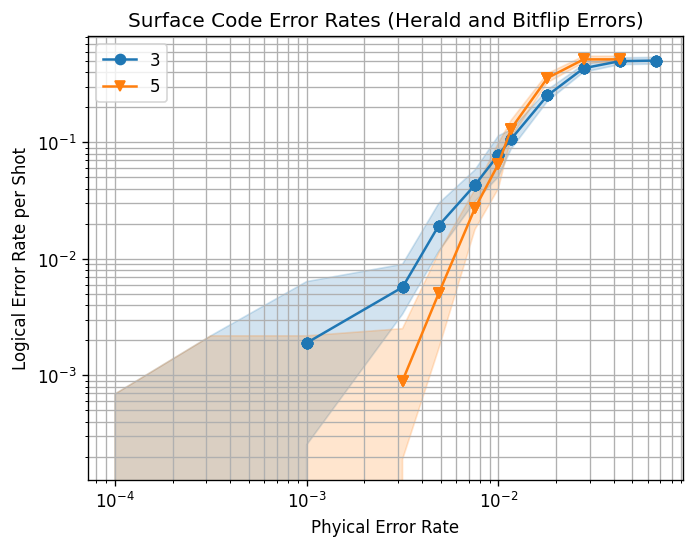

In [21]:
err_list_size = 3
d_list_size = 2
depol_factor = 3/10
bf_factor = 1/10

err_list = np.logspace(-3,-2,err_list_size)
d_list = [3, 5]




def generate_circuits():
    circ_list = []
    for p in err_list:
        for d in d_list:
            circ_list.append(rewriter(d, 
                                    p, 
                                    depol_factor,
                                    bf_factor,
                                    is_z_or_x = 'z',
                                    input_file = 'rotated_memory_z',
                                    output_file = f'out_2_rmz_{d}_{p}')['circuit'])
    return circ_list

circ_list = generate_circuits()

def generate_example_tasks():
    t = 0
    for p in err_list:
        for d in d_list:
            yield sinter.Task(
                circuit=circ_list[t],
                json_metadata={
                    'p': p,
                    'd': d,
                },
            )
            t += 1


collected_stats = list()
t = 0
for task in generate_example_tasks():
    task = [task]
    circ = circ_list[t]
    #print(circ)
    collected_stat: List[sinter.TaskStats] = sinter.collect(
        num_workers=5,
        tasks=task,
        decoders=['mwpf'],
        custom_decoders = { "mwpf": SinterMWPFDecoder(cluster_node_limit=50).with_circuit(circ) },
        max_shots=int(10**(3)),
        max_errors=int(10**(3)),
        # count_detection_events=True,
        hint_num_tasks = err_list_size*d_list_size,
        save_resume_filepath = "rot_z_one_det.csv",
        print_progress = True
        )
    collected_stats = collected_stats + collected_stat
    t+=1



# Render a matplotlib plot of the data.
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)
# ax.set_ylim(5e-6, 1e-1)
# ax.set_xlim(5e-6, 2e-1)
ax.loglog()
ax.set_title("Surface Code Error Rates (Herald and Bitflip Errors)")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120) 

In [22]:
err_list_size = 3
d_list_size = 2
depol_factor = 3/10
bf_factor = 1/10

err_list = np.logspace(-3,-2,err_list_size)
d_list = [3, 5]




def generate_circuits():
    circ_list = []
    for p in err_list:
        for d in d_list:
            circ_list.append(rewriter(d, 
                                    p, 
                                    depol_factor,
                                    bf_factor,
                                    is_z_or_x = 'z',
                                    input_file = 'rotated_memory_z',
                                    output_file = f'test_efficency_{d}_{p}')['circuit'])
    return circ_list

circ_list = generate_circuits()

def generate_example_tasks():
    t = 0
    for p in err_list:
        for d in d_list:
            yield sinter.Task(
                circuit=circ_list[t],
                json_metadata={
                    'p': p,
                    'd': d,
                },
            )
            t += 1


collected_stats = list()
t = 0
for task in generate_example_tasks():
    task = [task]
    circ = circ_list[t]
    #print(circ)
    collected_stat: List[sinter.TaskStats] = sinter.collect(
        num_workers=5,
        tasks=task,
        decoders=['mwpf'],
        custom_decoders = { "mwpf": SinterMWPFDecoder(cluster_node_limit=50).with_circuit(circ) },
        max_shots=int(10**(3)),
        max_errors=int(10**(3)),
        # count_detection_events=True,
        hint_num_tasks = err_list_size*d_list_size,
        save_resume_filepath = "test_efficency.csv",
        print_progress = True
        )
    collected_stats = collected_stats + collected_stat
    t+=1



# Render a matplotlib plot of the data.
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)
# ax.set_ylim(5e-6, 1e-1)
# ax.set_xlim(5e-6, 2e-1)
ax.loglog()
ax.set_title("Surface Code Error Rates (Herald and Bitflip Errors)")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120) 

Starting 5 workers...
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata
        5    mwpf <1m        999        1000 p=0.001,d=3  
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata
        5    mwpf <1m        600        1000 p=0.001,d=3  
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata
        5    mwpf <1m        560        1000 p=0.001,d=3  
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata
        5    mwpf <1m        400        1000 p=0.001,d=3  
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata
        5    mwpf <1m        360        1000 p=0.001,d=3  
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata
        5    mwpf <1m        200        1000 p=0.001,d=3  
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata
        5    mwpf <1m        183        1000 p=0.001,d=3  
1 tasks left:
  workers decoder eta shots_left errors_

: 

: 

## pymatching sanity check

In [ ]:
err_list_size = 3
d_list_size = 2

err_list = np.logspace(-2.5,-2,err_list_size)
d_list = [3, 5]


def generate_example_tasks():
    for p in err_list:
        for d in d_list:
            yield sinter.Task(
                circuit=rewriter(d, 
                                    p, 
                                    is_z_or_x = 'z',
                                    input_file = 'rotated_memory_z',
                                    output_file = f'out_2_rmz_{d}_{p}_pymatching')['circuit'],
                json_metadata={
                    'p': p,
                    'd': d,
                },
            )

def generate_circuits():
    circ_list = []
    for p in err_list:
        for d in d_list:
            circ_list.append(rewriter(d, 
                                    p, 
                                    is_z_or_x = 'z',
                                    input_file = 'rotated_memory_z',
                                    output_file = f'out_2_rmz_{d}_{p}_pymatching')['circuit'])
    return circ_list


collected_stats = list()
t = 0
circ_list = generate_circuits()
for task in generate_example_tasks():
    task = [task]
    circ = circ_list[t]
    #print(circ)
    collected_stat: List[sinter.TaskStats] = sinter.collect(
        num_workers=10,
        tasks=task,
        decoders=['pymatching','mwpf'],
        custom_decoders = { "mwpf": SinterMWPFDecoder().with_circuit(circ) },
        max_shots=int(10**(4)),
        max_errors=int(10**(4)),
        # count_detection_events=True,
        hint_num_tasks = err_list_size*d_list_size,
        save_resume_filepath = "rot_z_one_det_pymatching.csv",
        print_progress = True
        )
    collected_stats = collected_stats + collected_stat
    t+=1



# Render a matplotlib plot of the data.
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)
# ax.set_ylim(5e-6, 1e-1)
# ax.set_xlim(5e-6, 2e-1)
ax.loglog()
ax.set_title("Surface Code Error Rates (Herald and Bitflip Errors)")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120) 

Starting 10 workers...
Starting 10 workers...
Starting 10 workers...
Starting 10 workers...


# e

Starting 10 workers...
Starting 10 workers...
Starting 10 workers...
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata               
       10    mwpf <1m       3161        3162 p=0.00031622776601683794,d=3
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata               
       10    mwpf <1m       2812        3162 p=0.00031622776601683794,d=3
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata               
       10    mwpf <1m       2528        3162 p=0.00031622776601683794,d=3
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata               
       10    mwpf <1m       2496        3162 p=0.00031622776601683794,d=3
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata               
       10    mwpf <1m       1577        3162 p=0.00031622776601683794,d=3
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata               
       10    mwpf <1m       1192 

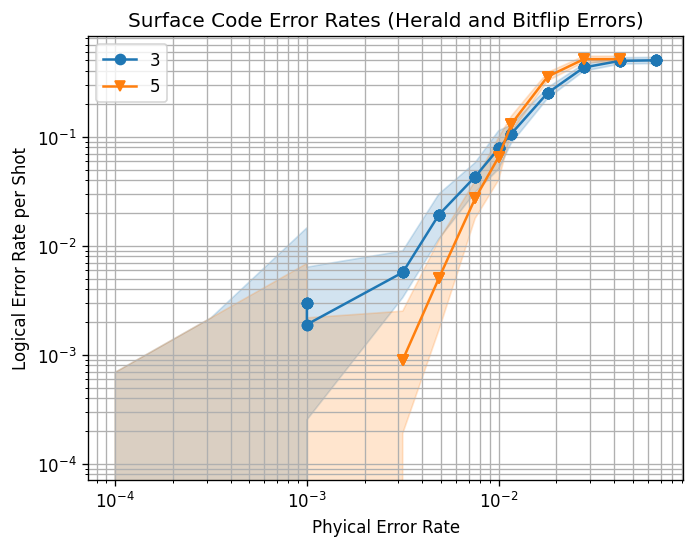

In [19]:
err_list_size = 3
d_list_size = 2

err_list = np.logspace(-4,-3,err_list_size)
d_list = [3, 5]


def generate_example_tasks():
    for p in err_list:
        for d in d_list:
            yield sinter.Task(
                circuit=rewriter(d, 
                                    p, 
                                    is_z_or_x = 'z',
                                    input_file = 'rotated_memory_z',
                                    output_file = f'out_2_rmz_{d}_{p}')['circuit'],
                json_metadata={
                    'p': p,
                    'd': d,
                },
            )

def generate_circuits():
    circ_list = []
    for p in err_list:
        for d in d_list:
            circ_list.append(rewriter(d, 
                                    p, 
                                    is_z_or_x = 'z',
                                    input_file = 'rotated_memory_z',
                                    output_file = f'out_2_rmz_{d}_{p}')['circuit'])
    return circ_list


collected_stats = list()
t = 0
circ_list = generate_circuits()
for task in generate_example_tasks():
    task = [task]
    circ = circ_list[t]
    #print(circ)
    collected_stat: List[sinter.TaskStats] = sinter.collect(
        num_workers=10,
        tasks=task,
        decoders=['mwpf'],
        custom_decoders = { "mwpf": SinterMWPFDecoder(cluster_node_limit=100).with_circuit(circ) },
        max_shots=int(10**(3.5)),
        max_errors=int(10**(3.5)),
        # count_detection_events=True,
        hint_num_tasks = err_list_size*d_list_size,
        save_resume_filepath = "rot_z_one_det.csv",
        print_progress = True
        )
    collected_stats = collected_stats + collected_stat
    t+=1



# Render a matplotlib plot of the data.
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)
# ax.set_ylim(5e-6, 1e-1)
# ax.set_xlim(5e-6, 2e-1)
ax.loglog()
ax.set_title("Surface Code Error Rates (Herald and Bitflip Errors)")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120) 

In [11]:
err_list_size = 10
d_list_size = 4

err_list = np.logspace(-2.5,-0.8,err_list_size)
d_list = [3, 5]


def generate_example_tasks():
    for p in err_list:
        for d in d_list:
            yield sinter.Task(
                circuit=rewriter(d, 
                                    p, 
                                    is_z_or_x = 'z',
                                    input_file = 'rotated_memory_z',
                                    output_file = f'out_2_rmz_{d}_{p}')['circuit'],
                json_metadata={
                    'p': p,
                    'd': d,
                },
            )

def generate_circuits():
    circ_list = []
    for p in err_list:
        for d in d_list:
            circ_list.append(rewriter(d, 
                                    p, 
                                    is_z_or_x = 'z',
                                    input_file = 'rotated_memory_z',
                                    output_file = f'out_2_rmz_{d}_{p}')['circuit'])
    return circ_list


collected_stats = list()
t = 0
circ_list = generate_circuits()
for task in generate_example_tasks():
    task = [task]
    circ = circ_list[t]
    #print(circ)
    collected_stat: List[sinter.TaskStats] = sinter.collect(
        num_workers=10,
        tasks=task,
        decoders=['mwpf'],
        custom_decoders = { "mwpf": SinterMWPFDecoder(cluster_node_limit=100).with_circuit(circ) },
        max_shots=int(10**(3.5)),
        max_errors=int(10**(3.5)),
        # count_detection_events=True,
        hint_num_tasks = err_list_size*d_list_size,
        save_resume_filepath = "rot_z_one_det.csv",
        print_progress = True
        )
    collected_stats = collected_stats + collected_stat
    t+=1



# Render a matplotlib plot of the data.
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)
# ax.set_ylim(5e-6, 1e-1)
# ax.set_xlim(5e-6, 2e-1)
ax.loglog()
ax.set_title("Surface Code Error Rates (Herald and Bitflip Errors)")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120) 

Starting 10 workers...
Starting 10 workers...
Starting 10 workers...
Starting 10 workers...
Starting 10 workers...
Starting 10 workers...
Starting 10 workers...
Starting 10 workers...
Starting 10 workers...
Starting 10 workers...
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata            
       10    mwpf  3m       3161        3162 p=0.01801173528334133,d=5
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata            
       10    mwpf  3m       3160        3162 p=0.01801173528334133,d=5
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata            
       10    mwpf  2m       3159        3162 p=0.01801173528334133,d=5
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata            
       10    mwpf  3m       3158        3162 p=0.01801173528334133,d=5
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata            
       10    mwpf  3m       3157        3162 p=0.018011735283

: 

: 

## many dets

In [10]:

def rewriter_4(distance:int, 
            p: float, 
            is_z_or_x:str,
            input_file:str,
            output_file:str):
    
    
    make_circuit(distance, p, is_z_or_x, input_file)

    erase_qubits = []
    herald_count_e = 0
    herald_count_m = 0
    indent = False
    meas_count = 0
    
    
    with open(input_file) as in_file, open(output_file, 'w') as out_file:

        for line in in_file:
            # print("meas_count", meas_count)
            erase_qubit_len = len(erase_qubits)
            num_meas = int((erase_qubit_len - 1)/2)
            num_meas_2 = int((erase_qubit_len + 1)/2)
            # print(num_meas_2)
            # print(herald_count_e, herald_count_m)

            while "DETECTOR(" in line:
                #print("herald count now", herald_count_m)
                new_line = fix_non_erase_detector(line, erase_qubit_len, herald_count_m)
                out_file.write(new_line)
                line = next(in_file)
                
                if "DETECTOR(" not in line:
                    herald_count_m = 0

            while line.startswith("QUBIT"):
                erase_qubits = count_erase_qubits(line, erase_qubits)
                out_file.write(line)
                line = next(in_file)

            if "OBSERVABLE" in line:
                new_line = fix_observable(line, erase_qubit_len)
                out_file.write(new_line)
                break

            
            out_file.write(line)

            if "{" in line:
                indent = True
            elif "}" in line:
                indent = False

            if ("TICK" in line):
                # ADD HERALD
                herald_count_e=add_erasures(out_file, p, erase_qubits, indent, herald_count_e)
                herald_count_m = herald_count_e
                meas_count += herald_count_e*erase_qubit_len
                detector_list = range(1, erase_qubit_len + 1)
                # print(detector_list )
                for det in detector_list:
                    if indent == True:
                        out_file.write(f'\t')
                    
                    out_file.write(f'DETECTOR rec[-{det}]\n')
                #herald_count_e = 0
            
            if ('M' in line):
                # ADD HERALD
                herald_count_e=add_erasures(out_file, p, erase_qubits, indent, herald_count_e)
                herald_count_m = herald_count_e
                #print(herald_count_e)
                meas_count += herald_count_m*erase_qubit_len
                # ADD DETECTORS
                if ('MR' in line):
                    # print("meas_count mr", meas_count)
                    meas_count+=num_meas
                    detector_list = range(1, erase_qubit_len + 1)
                    # print(detector_list )
                    # print("herald count", herald_count_e)
                    for det in detector_list:
                        if indent == True:
                            out_file.write(f'\t')
                        
                        if det > erase_qubit_len:
                            out_file.write(f'DETECTOR rec[-{det + num_meas}]\n')
                            
                        else:
                            out_file.write(f'DETECTOR rec[-{det}]\n')
                    
                            
                else:
                    # print("meas_count m", meas_count)
                    meas_count+= num_meas_2
                    detector_list = range(1, erase_qubit_len + 1)
                    # print(detector_list )
                    for det in detector_list:
                        if indent == True:
                            out_file.write(f'\t')
                       
                        if det > erase_qubit_len:
                            out_file.write(f'DETECTOR rec[-{det + num_meas_2}]\n')
                            
                        else:
                            out_file.write(f'DETECTOR rec[-{det}]\n')
                
                herald_count_e = 0
                

            

            

    c = stim.Circuit.from_file(output_file)
    #print(c.num_detectors)

    dem = mwpf.heralded_dem.HeraldedDetectorErrorModel.of(c)

    c = mwpf.heralded_dem.add_herald_detectors(c)

    return {'circuit':c ,'dem': dem}
    

In [ ]:
err_list_size = 8
d_list_size = 2

err_list = np.logspace(-3,-1.5,err_list_size)
d_list = [3, 5]


def generate_example_tasks_4():
    for p in err_list:
        for d in d_list:
            yield sinter.Task(
                circuit=rewriter_4(d, 
                                    p, 
                                    is_z_or_x = 'z',
                                    input_file = 'rotated_memory_z',
                                    output_file = f'out_4_rmz_{d}_{p}')['circuit'],
                json_metadata={
                    'p': p,
                    'd': d,
                },
            )

def generate_circuits_4():
    circ_list = []
    for p in err_list:
        for d in d_list:
            circ_list.append(rewriter_4(d, 
                                    p, 
                                    is_z_or_x = 'z',
                                    input_file = 'rotated_memory_z',
                                    output_file = f'out_4_rmz_{d}_{p}')['circuit'])
    return circ_list


collected_stats = list()
t = 0
circ_list = generate_circuits_4()
for task in generate_example_tasks_4():
    task = [task]
    circ = circ_list[t]
    #print(circ)
    collected_stat: List[sinter.TaskStats] = sinter.collect(
        num_workers=10,
        tasks=task,
        decoders=['mwpf'],
        custom_decoders = { "mwpf": SinterMWPFDecoder(cluster_node_limit=100).with_circuit(circ) },
        max_shots=int(10**(3.5)),
        max_errors=int(10**(3.5)),
        # count_detection_events=True,
        hint_num_tasks = err_list_size*d_list_size,
        save_resume_filepath = "rot_z_four_det.csv",
        print_progress = True
        )
    collected_stats = collected_stats + collected_stat
    t+=1



# Render a matplotlib plot of the data.
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)
# ax.set_ylim(5e-6, 1e-1)
# ax.set_xlim(5e-6, 2e-1)
ax.loglog()
ax.set_title("Surface Code Error Rates (Herald and Bitflip Errors)")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120) 

Starting 10 workers...
Starting 10 workers...
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata
       10    mwpf <1m       3161        3162 p=0.001,d=5  
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata
       10    mwpf <1m       3145        3162 p=0.001,d=5  
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata
       10    mwpf <1m       3017        3162 p=0.001,d=5  
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata
       10    mwpf <1m       2845        3162 p=0.001,d=5  
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata
       10    mwpf <1m       2844        3162 p=0.001,d=5  
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata
       10    mwpf <1m       2828        3162 p=0.001,d=5  
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata
       10    mwpf <1m       2804        3162 p=0.001,d=5  
1 tasks left:
  workers decode

## no node lim

In [11]:
err_list_size = 10
d_list_size = 4

err_list = np.logspace(-2.5,-0.8,err_list_size)
d_list = [3, 5]


def generate_example_tasks():
    for p in err_list:
        for d in d_list:
            yield sinter.Task(
                circuit=rewriter(d, 
                                    p, 
                                    is_z_or_x = 'z',
                                    input_file = 'rotated_memory_z',
                                    output_file = f'out_2_rmz_{d}_{p}_no_node_lim')['circuit'],
                json_metadata={
                    'p': p,
                    'd': d,
                },
            )

def generate_circuits():
    circ_list = []
    for p in err_list:
        for d in d_list:
            circ_list.append(rewriter(d, 
                                    p, 
                                    is_z_or_x = 'z',
                                    input_file = 'rotated_memory_z',
                                    output_file = f'out_2_rmz_{d}_{p}_no_node_lim')['circuit'])
    return circ_list


collected_stats = list()
t = 0
circ_list = generate_circuits()
for task in generate_example_tasks():
    task = [task]
    circ = circ_list[t]
    #print(circ)
    collected_stat: List[sinter.TaskStats] = sinter.collect(
        num_workers=10,
        tasks=task,
        decoders=['mwpf'],
        custom_decoders = { "mwpf": SinterMWPFDecoder().with_circuit(circ) },
        max_shots=int(10**(3.5)),
        max_errors=int(10**(3.5)),
        # count_detection_events=True,
        hint_num_tasks = err_list_size*d_list_size,
        save_resume_filepath = "rot_z_one_det_no_node_lim.csv",
        print_progress = True
        )
    collected_stats = collected_stats + collected_stat
    t+=1



# Render a matplotlib plot of the data.
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)
# ax.set_ylim(5e-6, 1e-1)
# ax.set_xlim(5e-6, 2e-1)
ax.loglog()
ax.set_title("Surface Code Error Rates (Herald and Bitflip Errors)")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120) 

Starting 10 workers...
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata              
       10    mwpf <1m       3145        3162 p=0.0031622776601683794,d=3
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata              
       10    mwpf <1m       3128        3162 p=0.0031622776601683794,d=3
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata              
       10    mwpf <1m       3111        3162 p=0.0031622776601683794,d=3
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata              
       10    mwpf <1m       2686        3161 p=0.0031622776601683794,d=3
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata              
       10    mwpf <1m       2423        3160 p=0.0031622776601683794,d=3
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata              
       10    mwpf <1m       2052        3158 p=0.0031622776601683794,d=3
1 tasks left:
  w

: 

: 

# every two rounds of CZs (2det)

In [10]:

def rewriter_2_det(distance:int, 
            error_in: float, 
            depol_factor: float, 
            bf_factor: float,
            is_z_or_x:str,
            input_file:str,
            output_file:str,
            erase_factor = 1):
    
    make_circuit(distance, error_in, depol_factor, bf_factor, is_z_or_x, input_file)

    erase_qubits = []
    herald_count_e = 0
    herald_count_m = 0
    indent = False
    meas_count = 0
    p = error_in * erase_factor

    
    
    
    with open(input_file) as in_file, open(output_file, 'w') as out_file:

        for line in in_file:
            # print("meas_count", meas_count)
            erase_qubit_len = len(erase_qubits)
            num_meas = int((erase_qubit_len - 1)/2)
            num_meas_2 = int((erase_qubit_len + 1)/2)
            # print(num_meas_2)
            # print(herald_count_e, herald_count_m)

            while "DETECTOR(" in line:
                #print("herald count now", herald_count_m)
                new_line = fix_non_erase_detector(line, erase_qubit_len, herald_count_m)
                out_file.write(new_line)
                line = next(in_file)
                
                if "DETECTOR(" not in line:
                    herald_count_m = 0

            while line.startswith("QUBIT"):
                erase_qubits = count_erase_qubits(line, erase_qubits)
                out_file.write(line)
                line = next(in_file)

            if "OBSERVABLE" in line:
                new_line = fix_observable(line, erase_qubit_len)
                out_file.write(new_line)
                break

            
            out_file.write(line)

            if "{" in line:
                indent = True
            elif "}" in line:
                indent = False

            if ("TICK" in line):
                # ADD HERALD
                herald_count_e=add_erasures(out_file, p, erase_qubits, indent, herald_count_e)
                herald_count_m = herald_count_e
                meas_count += herald_count_e*erase_qubit_len
            
            if ('M' in line):
                # ADD HERALD
                herald_count_e=add_erasures(out_file, p, erase_qubits, indent, herald_count_e)
                herald_count_m = herald_count_e
                #print(herald_count_e)
                meas_count += herald_count_m*erase_qubit_len
                # ADD DETECTORS
                if ('MR' in line):
                    # print("meas_count mr", meas_count)
                    meas_count+=num_meas
                    detector_list = range(1, herald_count_e*erase_qubit_len + 1)
                    # print(detector_list )
                    # print("herald count", herald_count_e)
                    for det in detector_list:
                        if indent == True:
                            out_file.write(f'\t')
                        
                        if det > erase_qubit_len:
                            out_file.write(f'DETECTOR rec[-{det + num_meas}]\n')
                            
                        else:
                            out_file.write(f'DETECTOR rec[-{det}]\n')
                            
                else:
                    # print("meas_count m", meas_count)
                    meas_count+= num_meas_2
                    detector_list = range(1, erase_qubit_len + 1)
                    # print(detector_list )
                    for det in detector_list:
                        if indent == True:
                            out_file.write(f'\t')
                       
                        if det > erase_qubit_len:
                            out_file.write(f'DETECTOR rec[-{det + num_meas_2}]\n')
                            
                        else:
                            out_file.write(f'DETECTOR rec[-{det}]\n')
                            

                
                
                herald_count_e = 0
                

            

            

    c = stim.Circuit.from_file(output_file)
    #print(c.num_detectors)

    dem = mwpf.heralded_dem.HeraldedDetectorErrorModel.of(c)

    c = mwpf.heralded_dem.add_herald_detectors(c)

    return {'circuit':c ,'dem': dem}
    

# after CX + before CX 

In [ ]:

def rewriter_2(distance:int, 
            p: float, 
            is_z_or_x:str,
            input_file:str,
            output_file:str):
    
    make_circuit(distance, p, is_z_or_x, input_file)

    erase_qubits = []
    herald_count_e = 0
    herald_count_m = 0
    indent = False
    meas_count = 0
    
    
    with open(input_file) as in_file, open(output_file, 'w') as out_file:

        for line in in_file:
            # print("meas_count", meas_count)
            erase_qubit_len = len(erase_qubits)
            num_meas = int((erase_qubit_len - 1)/2)
            num_meas_2 = int((erase_qubit_len + 1)/2)
            # print(num_meas_2)
            # print(herald_count_e, herald_count_m)

            while "DETECTOR(" in line:
                #print("herald count now", herald_count_m)
                new_line = fix_non_erase_detector(line, erase_qubit_len, herald_count_m)
                out_file.write(new_line)
                line = next(in_file)
                
                if "DETECTOR(" not in line:
                    herald_count_m = 0

            while line.startswith("QUBIT"):
                erase_qubits = count_erase_qubits(line, erase_qubits)
                out_file.write(line)
                line = next(in_file)

            if "OBSERVABLE" in line:
                new_line = fix_observable(line, erase_qubit_len)
                out_file.write(new_line)
                break

            
            out_file.write(line)

            if "{" in line:
                indent = True
            elif "}" in line:
                indent = False

            if ("TICK" in line):
                # ADD HERALD
                herald_count_e=add_erasures(out_file, p, erase_qubits, indent, herald_count_e)
                herald_count_m = herald_count_e
                meas_count += herald_count_e*erase_qubit_len

            if ("CX" in line):
                # ADD HERALD
                herald_count_e=add_erasures(out_file, p, erase_qubits, indent, herald_count_e)
                herald_count_m = herald_count_e
                meas_count += herald_count_e*erase_qubit_len
            
            if ('M' in line):
                # ADD HERALD
                herald_count_e=add_erasures(out_file, p, erase_qubits, indent, herald_count_e)
                herald_count_m = herald_count_e
                #print(herald_count_e)
                meas_count += herald_count_m*erase_qubit_len
                # ADD DETECTORS
                if ('MR' in line):
                    # print("meas_count mr", meas_count)
                    meas_count+=num_meas
                    detector_list = range(1, herald_count_e*erase_qubit_len + 1)
                    # print(detector_list )
                    # print("herald count", herald_count_e)
                    for det in detector_list:
                        if indent == True:
                            out_file.write(f'\t')
                        
                        if det > erase_qubit_len:
                            out_file.write(f'DETECTOR rec[-{det + num_meas}]\n')
                            
                        else:
                            out_file.write(f'DETECTOR rec[-{det}]\n')
                            
                else:
                    # print("meas_count m", meas_count)
                    meas_count+= num_meas_2
                    detector_list = range(1, erase_qubit_len + 1)
                    # print(detector_list )
                    for det in detector_list:
                        if indent == True:
                            out_file.write(f'\t')
                       
                        if det > erase_qubit_len:
                            out_file.write(f'DETECTOR rec[-{det + num_meas_2}]\n')
                            
                        else:
                            out_file.write(f'DETECTOR rec[-{det}]\n')

                
                herald_count_e = 0
                

            

            

    c = stim.Circuit.from_file(output_file)
    print(c.num_detectors)

    dem = mwpf.heralded_dem.HeraldedDetectorErrorModel.of(c)

    c = mwpf.heralded_dem.add_herald_detectors(c)

    return {'circuit':c ,'dem': dem}
    

# after every gate

In [ ]:

def rewriter_3(distance:int, 
            p: float, 
            is_z_or_x:str,
            input_file:str,
            output_file:str):
    
    make_circuit(distance, p, is_z_or_x, input_file)

    erase_qubits = []
    herald_count_e = 0
    herald_count_m = 0
    indent = False
    meas_count = 0
    
    
    with open(input_file) as in_file, open(output_file, 'w') as out_file:

        for line in in_file:
            # print("meas_count", meas_count)
            erase_qubit_len = len(erase_qubits)
            num_meas = int((erase_qubit_len - 1)/2)
            num_meas_2 = int((erase_qubit_len + 1)/2)
            # print(num_meas_2)
            # print(herald_count_e, herald_count_m)

            while "DETECTOR(" in line:
                #print("herald count now", herald_count_m)
                new_line = fix_non_erase_detector(line, erase_qubit_len, herald_count_m)
                out_file.write(new_line)
                line = next(in_file)
                
                if "DETECTOR(" not in line:
                    herald_count_m = 0

            while line.startswith("QUBIT"):
                erase_qubits = count_erase_qubits(line, erase_qubits)
                out_file.write(line)
                line = next(in_file)

            if "OBSERVABLE" in line:
                new_line = fix_observable(line, erase_qubit_len)
                out_file.write(new_line)
                break

            
            out_file.write(line)

            if "{" in line:
                indent = True
            elif "}" in line:
                indent = False

            if ("TICK" in line):
                # ADD HERALD
                herald_count_e=add_erasures(out_file, p, erase_qubits, indent, herald_count_e)
                herald_count_m = herald_count_e
                meas_count += herald_count_e*erase_qubit_len

            if ("CX" in line):
                # ADD HERALD
                herald_count_e=add_erasures(out_file, p, erase_qubits, indent, herald_count_e)
                herald_count_m = herald_count_e
                meas_count += herald_count_e*erase_qubit_len
            
            if ("H" in line):
                # ADD HERALD
                herald_count_e=add_erasures(out_file, p, erase_qubits, indent, herald_count_e)
                herald_count_m = herald_count_e
                meas_count += herald_count_e*erase_qubit_len
            
            if ('M' in line):
                # ADD HERALD
                herald_count_e=add_erasures(out_file, p, erase_qubits, indent, herald_count_e)
                herald_count_m = herald_count_e
                #print(herald_count_e)
                meas_count += herald_count_m*erase_qubit_len
                # ADD DETECTORS
                if ('MR' in line):
                    # print("meas_count mr", meas_count)
                    meas_count+=num_meas
                    detector_list = range(1, herald_count_e*erase_qubit_len + 1)
                    # print(detector_list )
                    # print("herald count", herald_count_e)
                    for det in detector_list:
                        if indent == True:
                            out_file.write(f'\t')
                        
                        if det > erase_qubit_len:
                            out_file.write(f'DETECTOR rec[-{det + num_meas}]\n')
                            
                        else:
                            out_file.write(f'DETECTOR rec[-{det}]\n')
                            
                else:
                    # print("meas_count m", meas_count)
                    meas_count+= num_meas_2
                    detector_list = range(1, erase_qubit_len + 1)
                    # print(detector_list )
                    for det in detector_list:
                        if indent == True:
                            out_file.write(f'\t')
                       
                        if det > erase_qubit_len:
                            out_file.write(f'DETECTOR rec[-{det + num_meas_2}]\n')
                            
                        else:
                            out_file.write(f'DETECTOR rec[-{det}]\n')

                
                herald_count_e = 0
                

            

            

    c = stim.Circuit.from_file(output_file)
    print(c.num_detectors)

    dem = mwpf.heralded_dem.HeraldedDetectorErrorModel.of(c)

    c = mwpf.heralded_dem.add_herald_detectors(c)

    return {'circuit':c ,'dem': dem}
    

# after every gate and error

In [ ]:

def rewriter_4(distance:int, 
            p: float, 
            is_z_or_x:str,
            input_file:str,
            output_file:str):
    
    make_circuit(distance, p, is_z_or_x, input_file)

    erase_qubits = []
    herald_count_e = 0
    herald_count_m = 0
    indent = False
    meas_count = 0
    
    
    with open(input_file) as in_file, open(output_file, 'w') as out_file:

        for line in in_file:
            # print("meas_count", meas_count)
            erase_qubit_len = len(erase_qubits)
            num_meas = int((erase_qubit_len - 1)/2)
            num_meas_2 = int((erase_qubit_len + 1)/2)
            # print(num_meas_2)
            # print(herald_count_e, herald_count_m)

            while "DETECTOR(" in line:
                #print("herald count now", herald_count_m)
                new_line = fix_non_erase_detector(line, erase_qubit_len, herald_count_m)
                out_file.write(new_line)
                line = next(in_file)
                
                if "DETECTOR(" not in line:
                    herald_count_m = 0

            while line.startswith("QUBIT"):
                erase_qubits = count_erase_qubits(line, erase_qubits)
                out_file.write(line)
                line = next(in_file)

            if "OBSERVABLE" in line:
                new_line = fix_observable(line, erase_qubit_len)
                out_file.write(new_line)
                break

            
            out_file.write(line)

            if "{" in line:
                indent = True
            elif "}" in line:
                indent = False

            if ("TICK" in line):
                # ADD HERALD
                herald_count_e=add_erasures(out_file, p, erase_qubits, indent, herald_count_e)
                herald_count_m = herald_count_e
                meas_count += herald_count_e*erase_qubit_len

            if ("CX" in line):
                # ADD HERALD
                herald_count_e=add_erasures(out_file, p, erase_qubits, indent, herald_count_e)
                herald_count_m = herald_count_e
                meas_count += herald_count_e*erase_qubit_len
            
            if ("H" in line):
                # ADD HERALD
                herald_count_e=add_erasures(out_file, p, erase_qubits, indent, herald_count_e)
                herald_count_m = herald_count_e
                meas_count += herald_count_e*erase_qubit_len
            
            if ('M' in line):
                # ADD HERALD
                herald_count_e=add_erasures(out_file, p, erase_qubits, indent, herald_count_e)
                herald_count_m = herald_count_e
                #print(herald_count_e)
                meas_count += herald_count_m*erase_qubit_len
                # ADD DETECTORS
                if ('MR' in line):
                    # print("meas_count mr", meas_count)
                    meas_count+=num_meas
                    detector_list = range(1, herald_count_e*erase_qubit_len + 1)
                    # print(detector_list )
                    # print("herald count", herald_count_e)
                    for det in detector_list:
                        if indent == True:
                            out_file.write(f'\t')
                        
                        if det > erase_qubit_len:
                            out_file.write(f'DETECTOR rec[-{det + num_meas}]\n')
                            
                        else:
                            out_file.write(f'DETECTOR rec[-{det}]\n')
                            
                else:
                    # print("meas_count m", meas_count)
                    meas_count+= num_meas_2
                    detector_list = range(1, erase_qubit_len + 1)
                    # print(detector_list )
                    for det in detector_list:
                        if indent == True:
                            out_file.write(f'\t')
                       
                        if det > erase_qubit_len:
                            out_file.write(f'DETECTOR rec[-{det + num_meas_2}]\n')
                            
                        else:
                            out_file.write(f'DETECTOR rec[-{det}]\n')

                
                herald_count_e = 0
                

            

            

    c = stim.Circuit.from_file(output_file)
    print(c.num_detectors)

    dem = mwpf.heralded_dem.HeraldedDetectorErrorModel.of(c)

    c = mwpf.heralded_dem.add_herald_detectors(c)

    return {'circuit':c ,'dem': dem}
    

# Simultaneous erasure and pauli circuit


In [ ]:
err_list_size = 6
d_list_size = 2
depol_factor = 3/10
bf_factor = 1/10

err_list = np.logspace(-2.6,-0.9,err_list_size)
d_list = [3, 5]




def generate_circuits():
    pauli_circ_list = []
    erasure_circuit_list = []
    for p in err_list:
        for d in d_list:
            erasure_circuit_list.append(rewriter(d, 
                                    p, 
                                    0,
                                    0,
                                    is_z_or_x = 'z',
                                    input_file = 'rotated_memory_z',
                                    output_file = f'test_2_two_circ_method_{d}_{p}_erase')['circuit'])
            pauli_circ_list.append(rewriter(d, 
                                    p, 
                                    depol_factor,
                                    bf_factor,
                                    is_z_or_x = 'z',
                                    input_file = 'rotated_memory_z',
                                    output_file = f'test_2_two_circ_method_{d}_{p}_pauli',
                                    erase_factor=0)['circuit'])
    return erasure_circuit_list, pauli_circ_list

erasure_circ_list, pauli_circ_list = generate_circuits()

def generate_example_tasks(circ_list):
    t = 0
    for p in err_list:
        for d in d_list:
            yield sinter.Task(
                circuit=circ_list[t],
                json_metadata={
                    'p': p,
                    'd': d,
                },
            )
            t += 1




e_collected_stats = list()
t = 0
for task in generate_example_tasks(erasure_circ_list):
    task = [task]
    circ = erasure_circ_list[t]
    #print(circ)
    collected_stat: List[sinter.TaskStats] = sinter.collect(
        num_workers=10,
        tasks=task,
        decoders=['mwpf'],
        custom_decoders = { "mwpf": SinterMWPFDecoder(cluster_node_limit=200).with_circuit(circ) },
        max_shots=int(10**(3)),
        max_errors=int(10**(3)),
        # count_detection_events=True,
        hint_num_tasks = err_list_size*d_list_size,
        save_resume_filepath = "test_2_two_circ_method_erasure.csv",
        print_progress = True
        )
    e_collected_stats = e_collected_stats + collected_stat
    t+=1

p_collected_stats = list()
t = 0
for task in generate_example_tasks(pauli_circ_list):
    task = [task]
    #print(circ)
    collected_stat: List[sinter.TaskStats] = sinter.collect(
        num_workers=5,
        tasks=task,
        decoders=['pymatching'],
        max_shots=int(10**(4)),
        max_errors=int(10**(4)),
        # count_detection_events=True,
        hint_num_tasks = err_list_size*d_list_size,
        save_resume_filepath = "test_2_two_circ_method_pauli.csv",
        print_progress = True
        )
    p_collected_stats = p_collected_stats + collected_stat
    t+=1








Starting 10 workers...


In [ ]:
! sinter combine test_two_circ_method_pauli.csv > combined_test_two_circ_method_pauli.csv
! sinter combine test_two_circ_method_erasure.csv > combined_test_two_circ_method_erasure.csv

In [ ]:

e_collected_stats = sinter.stats_from_csv_files("combined_test_2_two_circ_method_erasure.csv")
p_collected_stats = sinter.stats_from_csv_files("combined_test_2_two_circ_method_pauli.csv")

pd_e = pd.read_csv("combined_test_2_two_circ_method_erasure.csv")
pd_p = pd.read_csv("combined_test_2_two_circ_method_pauli.csv")

pd_merged = pd_e


pd_merged['    errors'] = 10* pd_e['    errors'] + pd_p['    errors']
pd_merged['     shots'] = 10* pd_e['     shots'] + pd_p['     shots']

pd_merged.to_csv('e_and_p_2_two_circ_method.csv')

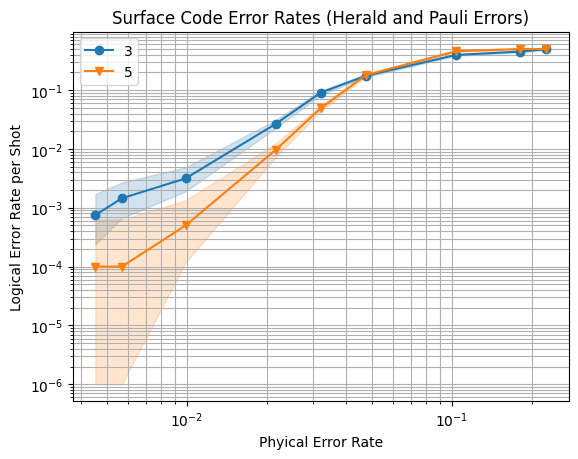

In [4]:
e_and_p_stats_2 = sinter.stats_from_csv_files('e_and_p_2_two_circ_method.csv')


# Render a matplotlib plot of the data.
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=e_and_p_stats_2,
    x_func=lambda stats: (18/10)* stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)
ax.loglog()
ax.set_title("Surface Code Error Rates (Herald and Pauli Errors)")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()

In [2]:
e_stats_2 = sinter.stats_from_csv_files('test_2_two_circ_method_erasure.csv')


# Render a matplotlib plot of the data.
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=e_stats_2,
    x_func=lambda stats:  stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)
ax.loglog()
ax.set_title("Surface Code Error Rates (Herald Errors Only)")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()

NameError: name 'sinter' is not defined

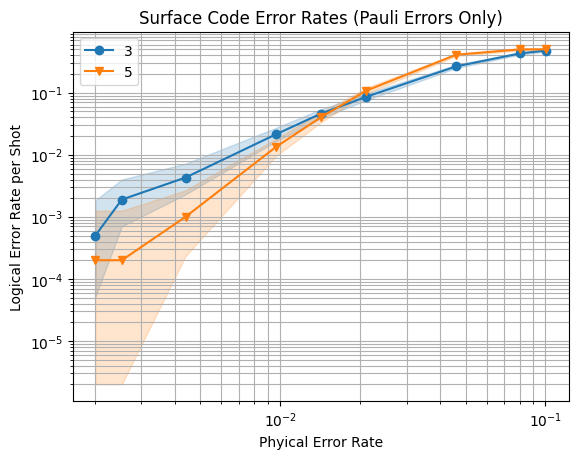

In [21]:
p_stats_2 = sinter.stats_from_csv_files('combined_test_2_two_circ_method_pauli.csv')


# Render a matplotlib plot of the data.
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=p_stats_2,
    x_func=lambda stats: (8/10)* stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)
ax.loglog()
ax.set_title("Surface Code Error Rates (Pauli Errors Only)")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()

In [ ]:
err_list_size = 6
d_list_size = 1
depol_factor = 3/10
bf_factor = 1/10

err_list = np.logspace(-2.6,-0.9,err_list_size)
d_list = [7]




def generate_circuits():
    pauli_circ_list = []
    erasure_circuit_list = []
    for p in err_list:
        for d in d_list:
            erasure_circuit_list.append(rewriter(d, 
                                    p, 
                                    0,
                                    0,
                                    is_z_or_x = 'z',
                                    input_file = 'rotated_memory_z',
                                    output_file = f'test_2_two_circ_method_{d}_{p}_erase')['circuit'])
            pauli_circ_list.append(rewriter(d, 
                                    p, 
                                    depol_factor,
                                    bf_factor,
                                    is_z_or_x = 'z',
                                    input_file = 'rotated_memory_z',
                                    output_file = f'test_2_two_circ_method_{d}_{p}_pauli',
                                    erase_factor=0)['circuit'])
    return erasure_circuit_list, pauli_circ_list

erasure_circ_list, pauli_circ_list = generate_circuits()

def generate_example_tasks(circ_list):
    t = 0
    for p in err_list:
        for d in d_list:
            yield sinter.Task(
                circuit=circ_list[t],
                json_metadata={
                    'p': p,
                    'd': d,
                },
            )
            t += 1




e_collected_stats = list()
t = 0
for task in generate_example_tasks(erasure_circ_list):
    task = [task]
    circ = erasure_circ_list[t]
    #print(circ)
    collected_stat: List[sinter.TaskStats] = sinter.collect(
        num_workers=10,
        tasks=task,
        decoders=['mwpf'],
        custom_decoders = { "mwpf": SinterMWPFDecoder(cluster_node_limit=300).with_circuit(circ) },
        max_shots=int(10**(3)),
        max_errors=int(10**(3)),
        # count_detection_events=True,
        hint_num_tasks = err_list_size*d_list_size,
        save_resume_filepath = "d7_two_circ_method_erasure.csv",
        print_progress = True
        )
    e_collected_stats = e_collected_stats + collected_stat
    t+=1

p_collected_stats = list()
t = 0
for task in generate_example_tasks(pauli_circ_list):
    task = [task]
    #print(circ)
    collected_stat: List[sinter.TaskStats] = sinter.collect(
        num_workers=5,
        tasks=task,
        decoders=['pymatching'],
        max_shots=int(10**(4)),
        max_errors=int(10**(4)),
        # count_detection_events=True,
        hint_num_tasks = err_list_size*d_list_size,
        save_resume_filepath = "d7_two_circ_method_pauli.csv",
        print_progress = True
        )
    p_collected_stats = p_collected_stats + collected_stat
    t+=1








Starting 10 workers...


In [ ]:
! sinter combine test_two_circ_method_pauli.csv > combined_test_two_circ_method_pauli.csv
! sinter combine test_two_circ_method_erasure.csv > combined_test_two_circ_method_erasure.csv

In [ ]:

e_collected_stats = sinter.stats_from_csv_files("combined_test_two_circ_method_erasure.csv")
p_collected_stats = sinter.stats_from_csv_files("combined_test_two_circ_method_pauli.csv")

pd_e = pd.read_csv("combined_test_two_circ_method_erasure.csv")
pd_p = pd.read_csv("combined_test_two_circ_method_pauli.csv")

pd_merged = pd_e


pd_merged['    errors'] = pd_e['    errors'] + pd_p['    errors']
pd_merged['     shots'] = pd_e['     shots'] + pd_p['     shots']

pd_merged.to_csv('e_and_p_two_circ_method.csv')

In [ ]:
e_and_p_stats = sinter.stats_from_csv_files("e_and_p_two_circ_method.csv")

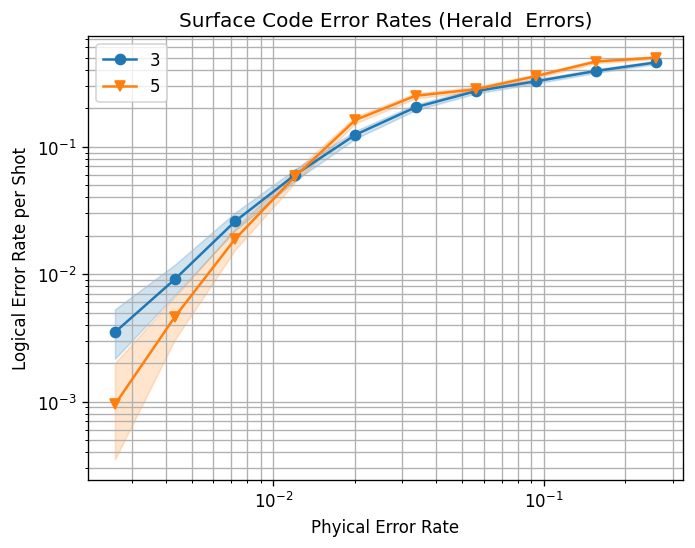

In [ ]:
e_and_p_stats = sinter.stats_from_csv_files("e_and_p_two_circ_method.csv")


# Render a matplotlib plot of the data.
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=e_and_p_stats,
    x_func=lambda stats: (13/5)* stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)
ax.loglog()
ax.set_title("Surface Code Error Rates (Herald  Errors)")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120) 


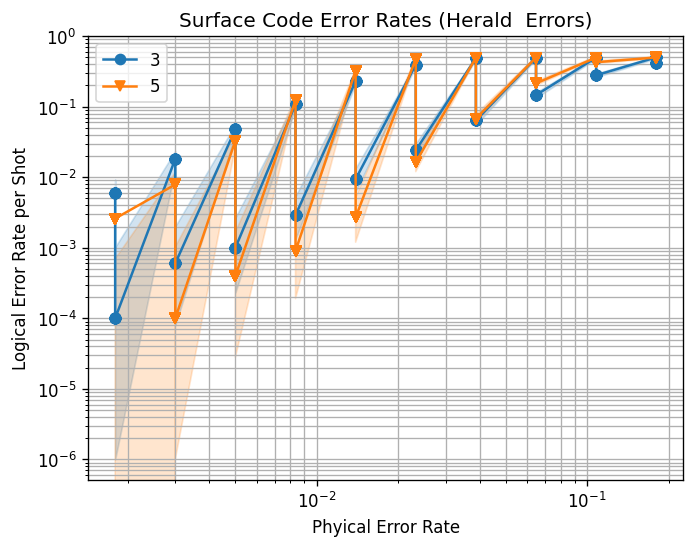

In [80]:

# Render a matplotlib plot of the data.
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=(e_collected_stats + p_collected_stats),
    x_func=lambda stats: ((18/10)*stats.json_metadata['p']),
    group_func=lambda stats: stats.json_metadata['d'],
)
ax.loglog()
ax.set_title("Surface Code Error Rates (Herald  Errors)")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120) 


In [ ]:
def merge_stats(e_collected_stats, p_collected_stats):

    # x_func=lambda e_collected_stats: (18/10)*e_collected_stats.json_metadata['p']
    group_func_by_p=lambda e_collected_stats: e_collected_stats.json_metadata['p']
    grouped_by_p_stats = sinter.group_by(e_collected_stats, key = group_func_by_p)

    group_func_by_d=lambda e_collected_stats: e_collected_stats.json_metadata['d']
    grouped_by_d_stats = sinter.group_by(e_collected_stats, key = group_func_by_d)

    print(list(grouped_by_d_stats.keys()))

    for key in list(grouped_by_d_stats.keys()):
        in_there = grouped_by_d_stats[key]
        


    #[set(grouped_by_p_stats[key]) for key in list(grouped_by_d_stats.keys())]
    #[set(stat) for stat in grouped_by_d_stats]

    



    
    

   

In [73]:
merge_stats(e_collected_stats, p_collected_stats)

[3, 5]
<class 'list'>


TypeError: unhashable type: 'dict'

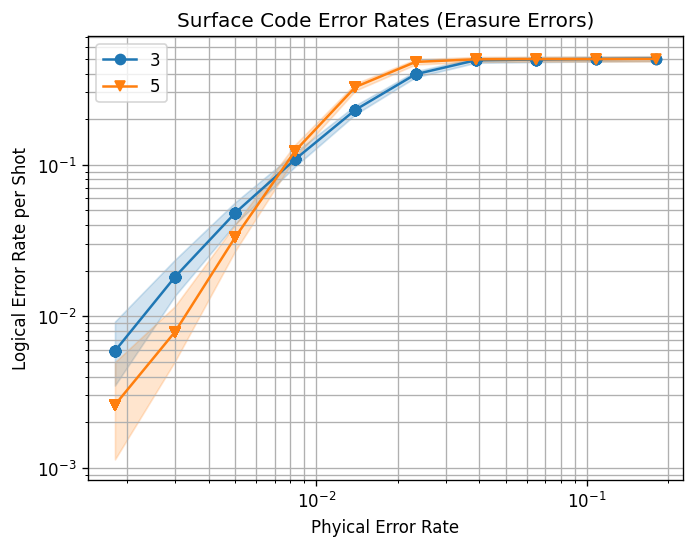

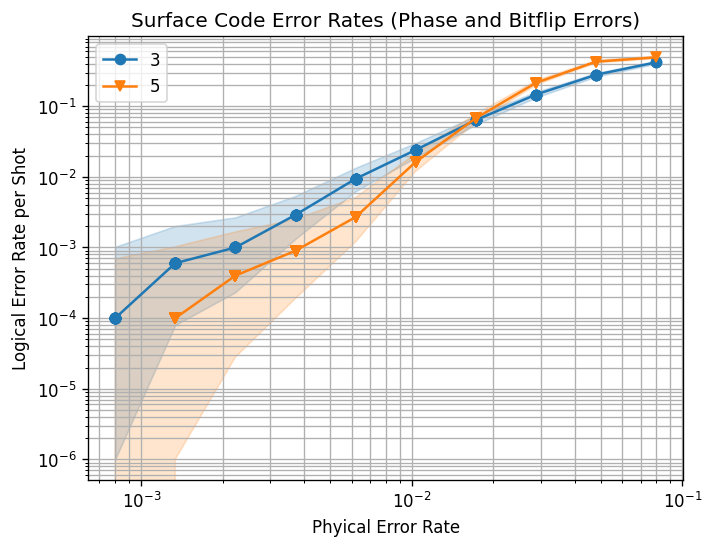

In [74]:

# Render a matplotlib plot of the data.
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=e_collected_stats,
    x_func=lambda stats: (18/10)* stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)
ax.loglog()
ax.set_title("Surface Code Error Rates (Erasure Errors)")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120) 

fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=p_collected_stats,
    x_func=lambda stats: (8/10) * stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)
# ax.set_ylim(5e-6, 1e-1)
# ax.set_xlim(5e-6, 2e-1)
ax.loglog()
ax.set_title("Surface Code Error Rates (Phase and Bitflip Errors)")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120) 

# more shots

In [59]:
10/18


0.5555555555555556

In [67]:
err_list_size = 8
d_list_size = 2
erase_factor = 5.5/10
depol_factor = (((1 - erase_factor)/4) * 3) / 2
bf_factor = (((1 - erase_factor)/4)) / 2

err_list = np.logspace(-2.6,-0.9,err_list_size)
d_list = [3, 5]




def generate_circuits():
    pauli_circ_list = []
    erasure_circuit_list = []
    for p in err_list:
        for d in d_list:
            erasure_circuit_list.append(rewriter(d, 
                                    p, 
                                    0,
                                    0,
                                    is_z_or_x = 'z',
                                    input_file = 'rotated_memory_z',
                                    output_file = f'higher_e_{d}_{p}_erase',
                                    erase_factor = erase_factor)['circuit'])
            pauli_circ_list.append(rewriter(d, 
                                    p, 
                                    depol_factor,
                                    bf_factor,
                                    is_z_or_x = 'z',
                                    input_file = 'rotated_memory_z',
                                    output_file = f'higher_e_{d}_{p}_pauli',
                                    erase_factor=0)['circuit'])
    return erasure_circuit_list, pauli_circ_list

erasure_circ_list, pauli_circ_list = generate_circuits()

def generate_example_tasks(circ_list):
    t = 0
    for p in err_list:
        for d in d_list:
            yield sinter.Task(
                circuit=circ_list[t],
                json_metadata={
                    'p': p,
                    'd': d,
                },
            )
            t += 1




e_collected_stats = list()
t = 0
for task in generate_example_tasks(erasure_circ_list):
    task = [task]
    circ = erasure_circ_list[t]
    #print(circ)
    collected_stat: List[sinter.TaskStats] = sinter.collect(
        num_workers=8,
        tasks=task,
        decoders=['mwpf'],
        custom_decoders = { "mwpf": SinterMWPFDecoder(cluster_node_limit=200).with_circuit(circ) },
        max_shots=int(10**(4)),
        max_errors=int(10**(4)),
        # count_detection_events=True,
        hint_num_tasks = err_list_size*d_list_size,
        save_resume_filepath = "more_shots_erasure.csv",
        print_progress = True
        )
    e_collected_stats = e_collected_stats + collected_stat
    t+=1

p_collected_stats = list()
t = 0
for task in generate_example_tasks(pauli_circ_list):
    task = [task]
    #print(circ)
    collected_stat: List[sinter.TaskStats] = sinter.collect(
        num_workers=5,
        tasks=task,
        decoders=['pymatching'],
        max_shots=int(10**(4)),
        max_errors=int(10**(4)),
        # count_detection_events=True,
        hint_num_tasks = err_list_size*d_list_size,
        save_resume_filepath = "more_shots_pauli.csv",
        print_progress = True
        )
    p_collected_stats = p_collected_stats + collected_stat
    t+=1








Starting 8 workers...
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata              
        8    mwpf <1m       9999       10000 p=0.0025118864315095794,d=3
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata              
        8    mwpf <1m       9727       10000 p=0.0025118864315095794,d=3
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata              
        8    mwpf <1m       8750       10000 p=0.0025118864315095794,d=3
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata              
        8    mwpf <1m       8594       10000 p=0.0025118864315095794,d=3
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata              
        8    mwpf <1m       8302       10000 p=0.0025118864315095794,d=3
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata              
        8    mwpf <1m       7500       10000 p=0.0025118864315095794,d=3
1 tasks left:
  wo

In [ ]:

e_collected_stats = sinter.stats_from_csv_files("combined_more_shots_erasure.csv")
p_collected_stats = sinter.stats_from_csv_files("combined_more_shots_pauli.csv")

pd_e = pd.read_csv("combined_more_shots_erasure.csv")
pd_p = pd.read_csv("combined_more_shots_pauli.csv")

pd_merged = pd_e


pd_merged['    errors'] = pd_e['    errors'] + pd_p['    errors']
pd_merged['     shots'] = pd_e['     shots'] + pd_p['     shots']

pd_merged.to_csv('e_and_p_more_shots.csv')

In [ ]:
e_and_p_stats_more_shots = sinter.stats_from_csv_files('e_and_p_more_shots.csv')


# Render a matplotlib plot of the data.
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=e_and_p_stats_more_shots,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d']
)

plt.xlim(2e-3,2e-1)
plt.ylim(1e-6,1)
ax.loglog()
ax.set_title("Surface Code Error Rates (Herald and Pauli Errors)")
ax.set_xlabel("Phyical Error Rate ")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.vlines(5.1e-2, 1e-9, 1, "red")
ax.legend()

In [68]:
! sinter combine more_shots_pauli.csv > combined_more_shots_pauli.csv
! sinter combine more_shots_erasure.csv > combined_more_shots_erasure.csv

In [69]:

e_collected_stats = sinter.stats_from_csv_files("combined_more_shots_erasure.csv")
p_collected_stats = sinter.stats_from_csv_files("combined_more_shots_pauli.csv")

pd_e = pd.read_csv("combined_more_shots_erasure.csv")
pd_p = pd.read_csv("combined_more_shots_pauli.csv")

pd_merged = pd_e


pd_merged['    errors'] = pd_e['    errors'] + pd_p['    errors']
pd_merged['     shots'] = pd_e['     shots'] + pd_p['     shots']

pd_merged.to_csv('e_and_p_more_shots.csv')

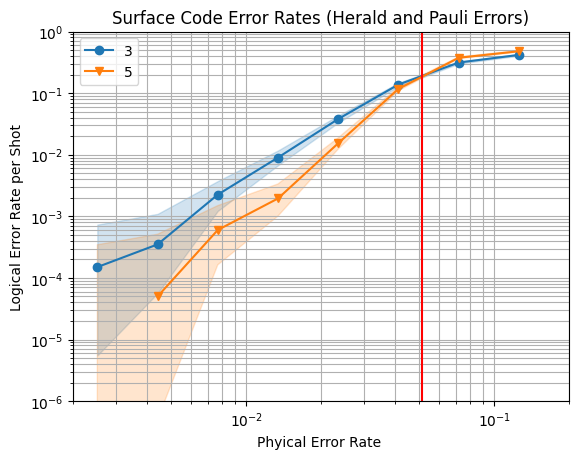

In [ ]:
e_and_p_stats_more_shots = sinter.stats_from_csv_files('e_and_p_more_shots.csv')


# Render a matplotlib plot of the data.
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=e_and_p_stats_more_shots,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d']
)

plt.xlim(2e-3,2e-1)
plt.ylim(1e-6,1)
ax.loglog()
ax.set_title("Surface Code Error Rates (Herald and Pauli Errors)")
ax.set_xlabel("Phyical Error Rate ")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.vlines(5.1e-2, 1e-9, 1, "red")
ax.legend()

# lowering erasure error fraction

In [ ]:
err_list_size = 6
d_list_size = 2
depol_factor = 3/10
bf_factor = 1/10

err_list = np.logspace(-2.6,-0.9,err_list_size)
d_list = [3, 5]




def generate_circuits():
    pauli_circ_list = []
    erasure_circuit_list = []
    for p in err_list:
        for d in d_list:
            erasure_circuit_list.append(rewriter(d, 
                                    p, 
                                    0,
                                    0,
                                    is_z_or_x = 'z',
                                    input_file = 'rotated_memory_z',
                                    output_file = f'test_2_two_circ_method_{d}_{p}_erase',
                                    erase_factor = 7/10)['circuit'])
            pauli_circ_list.append(rewriter(d, 
                                    p, 
                                    depol_factor,
                                    bf_factor,
                                    is_z_or_x = 'z',
                                    input_file = 'rotated_memory_z',
                                    output_file = f'test_2_two_circ_method_{d}_{p}_pauli',
                                    erase_factor=0)['circuit'])
    return erasure_circuit_list, pauli_circ_list

erasure_circ_list, pauli_circ_list = generate_circuits()

def generate_example_tasks(circ_list):
    t = 0
    for p in err_list:
        for d in d_list:
            yield sinter.Task(
                circuit=circ_list[t],
                json_metadata={
                    'p': p,
                    'd': d,
                },
            )
            t += 1




e_collected_stats = list()
t = 0
for task in generate_example_tasks(erasure_circ_list):
    task = [task]
    circ = erasure_circ_list[t]
    #print(circ)
    collected_stat: List[sinter.TaskStats] = sinter.collect(
        num_workers=8,
        tasks=task,
        decoders=['mwpf'],
        custom_decoders = { "mwpf": SinterMWPFDecoder(cluster_node_limit=200).with_circuit(circ) },
        max_shots=int(10**(3)),
        max_errors=int(10**(3)),
        # count_detection_events=True,
        hint_num_tasks = err_list_size*d_list_size,
        save_resume_filepath = "lower_e_fraction_erasure.csv",
        print_progress = True
        )
    e_collected_stats = e_collected_stats + collected_stat
    t+=1

p_collected_stats = list()
t = 0
for task in generate_example_tasks(pauli_circ_list):
    task = [task]
    #print(circ)
    collected_stat: List[sinter.TaskStats] = sinter.collect(
        num_workers=5,
        tasks=task,
        decoders=['pymatching'],
        max_shots=int(10**(4)),
        max_errors=int(10**(4)),
        # count_detection_events=True,
        hint_num_tasks = err_list_size*d_list_size,
        save_resume_filepath = "higher_e_fraction_pauli.csv",
        print_progress = True
        )
    p_collected_stats = p_collected_stats + collected_stat
    t+=1








Starting 8 workers...
Starting 8 workers...
Starting 8 workers...
Starting 8 workers...
Starting 8 workers...
Starting 8 workers...
Starting 8 workers...
Starting 8 workers...
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata             
        8    mwpf <1m        199         946 p=0.026302679918953815,d=5
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata             
        8    mwpf <1m        197         946 p=0.026302679918953815,d=5
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata             
        8    mwpf <1m        175         945 p=0.026302679918953815,d=5
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata             
        8    mwpf <1m        172         945 p=0.026302679918953815,d=5
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata             
        8    mwpf <1m        171         945 p=0.026302679918953815,d=5
1 tasks left:
  workers decoder et

# INCREASING error fraction

In [11]:
err_list_size = 6
d_list_size = 2
erase_factor = 7/10
depol_factor = (((1 - erase_factor)/4) * 3) / 2
bf_factor = (((1 - erase_factor)/4)) / 2

err_list = np.logspace(-2.6,-0.9,err_list_size)
d_list = [3, 5]




def generate_circuits():
    pauli_circ_list = []
    erasure_circuit_list = []
    for p in err_list:
        for d in d_list:
            erasure_circuit_list.append(rewriter(d, 
                                    p, 
                                    0,
                                    0,
                                    is_z_or_x = 'z',
                                    input_file = 'rotated_memory_z',
                                    output_file = f'higher_e_{d}_{p}_erase',
                                    erase_factor = erase_factor)['circuit'])
            pauli_circ_list.append(rewriter(d, 
                                    p, 
                                    depol_factor,
                                    bf_factor,
                                    is_z_or_x = 'z',
                                    input_file = 'rotated_memory_z',
                                    output_file = f'higher_e_{d}_{p}_pauli',
                                    erase_factor=0)['circuit'])
    return erasure_circuit_list, pauli_circ_list

erasure_circ_list, pauli_circ_list = generate_circuits()

def generate_example_tasks(circ_list):
    t = 0
    for p in err_list:
        for d in d_list:
            yield sinter.Task(
                circuit=circ_list[t],
                json_metadata={
                    'p': p,
                    'd': d,
                },
            )
            t += 1




e_collected_stats = list()
t = 0
for task in generate_example_tasks(erasure_circ_list):
    task = [task]
    circ = erasure_circ_list[t]
    #print(circ)
    collected_stat: List[sinter.TaskStats] = sinter.collect(
        num_workers=8,
        tasks=task,
        decoders=['mwpf'],
        custom_decoders = { "mwpf": SinterMWPFDecoder(cluster_node_limit=200).with_circuit(circ) },
        max_shots=int(10**(4)),
        max_errors=int(10**(4)),
        # count_detection_events=True,
        hint_num_tasks = err_list_size*d_list_size,
        save_resume_filepath = "higher_e_fraction_erasure.csv",
        print_progress = True
        )
    e_collected_stats = e_collected_stats + collected_stat
    t+=1

p_collected_stats = list()
t = 0
for task in generate_example_tasks(pauli_circ_list):
    task = [task]
    #print(circ)
    collected_stat: List[sinter.TaskStats] = sinter.collect(
        num_workers=5,
        tasks=task,
        decoders=['pymatching'],
        max_shots=int(10**(4)),
        max_errors=int(10**(4)),
        # count_detection_events=True,
        hint_num_tasks = err_list_size*d_list_size,
        save_resume_filepath = "higher_e_fraction_pauli.csv",
        print_progress = True
        )
    p_collected_stats = p_collected_stats + collected_stat
    t+=1








KeyboardInterrupt: 

[0.00158489 0.00286512 0.00517947 0.00936329 0.01692667 0.0305995
 0.05531681 0.1       ]
[0.00251189 0.00439397 0.00768625 0.01344533 0.02351953 0.04114203
 0.07196857 0.12589254]


In [11]:
err_list_size = 10
d_list_size = 2
erase_factor = 7/10
depol_factor = (((1 - erase_factor)/4) * 3) / 2
bf_factor = (((1 - erase_factor)/4)) / 2

err_list = np.logspace(-2.6,-0.9,err_list_size)
d_list = [3, 5]




def generate_circuits():
    pauli_circ_list = []
    erasure_circuit_list = []
    for p in err_list:
        for d in d_list:
            erasure_circuit_list.append(rewriter(d, 
                                    p, 
                                    0,
                                    0,
                                    is_z_or_x = 'z',
                                    input_file = 'rotated_memory_z',
                                    output_file = f'higher_e_{d}_{p}_erase',
                                    erase_factor = erase_factor)['circuit'])
            pauli_circ_list.append(rewriter(d, 
                                    p, 
                                    depol_factor,
                                    bf_factor,
                                    is_z_or_x = 'z',
                                    input_file = 'rotated_memory_z',
                                    output_file = f'higher_e_{d}_{p}_pauli',
                                    erase_factor=0)['circuit'])
    return erasure_circuit_list, pauli_circ_list

erasure_circ_list, pauli_circ_list = generate_circuits()

def generate_example_tasks(circ_list):
    t = 0
    for p in err_list:
        for d in d_list:
            yield sinter.Task(
                circuit=circ_list[t],
                json_metadata={
                    'p': p,
                    'd': d,
                },
            )
            t += 1




e_collected_stats = list()
t = 0
for task in generate_example_tasks(erasure_circ_list):
    task = [task]
    circ = erasure_circ_list[t]
    #print(circ)
    collected_stat: List[sinter.TaskStats] = sinter.collect(
        num_workers=10,
        tasks=task,
        decoders=['mwpf'],
        custom_decoders = { "mwpf": SinterMWPFDecoder(cluster_node_limit=200).with_circuit(circ) },
        max_shots=int(10**(4)),
        max_errors=int(10**(4)),
        # count_detection_events=True,
        hint_num_tasks = err_list_size*d_list_size,
        save_resume_filepath = "higher_e_fraction_erasure_2.csv",
        print_progress = True
        )
    e_collected_stats = e_collected_stats + collected_stat
    t+=1

p_collected_stats = list()
t = 0
for task in generate_example_tasks(pauli_circ_list):
    task = [task]
    #print(circ)
    collected_stat: List[sinter.TaskStats] = sinter.collect(
        num_workers=5,
        tasks=task,
        decoders=['pymatching'],
        max_shots=int(10**(4)),
        max_errors=int(10**(4)),
        # count_detection_events=True,
        hint_num_tasks = err_list_size*d_list_size,
        save_resume_filepath = "higher_e_fraction_pauli_2.csv",
        print_progress = True
        )
    p_collected_stats = p_collected_stats + collected_stat
    t+=1








Starting 10 workers...
Starting 10 workers...
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata              
       10    mwpf <1m       9999       10000 p=0.0025118864315095794,d=5
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata              
       10    mwpf <1m       9998       10000 p=0.0025118864315095794,d=5
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata              
       10    mwpf <1m       9982       10000 p=0.0025118864315095794,d=5
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata              
       10    mwpf <1m       9718       10000 p=0.0025118864315095794,d=5
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata              
       10    mwpf <1m       9462       10000 p=0.0025118864315095794,d=5
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata              
       10    mwpf <1m       9206       10000 p=0.002511886431509579

In [12]:
! sinter combine higher_e_fraction_pauli_2.csv > combined_higher_e_fraction_pauli_2.csv
! sinter combine higher_e_fraction_erasure_2.csv > combined_higher_e_fraction_erasure_2.csv

In [ ]:

e_collected_stats = sinter.stats_from_csv_files("combined_higher_e_fraction_erasure_2.csv")
p_collected_stats = sinter.stats_from_csv_files("combined_higher_e_fraction_pauli_2.csv")

pd_e = pd.read_csv("combined_higher_e_fraction_erasure_2.csv")
pd_p = pd.read_csv("combined_higher_e_fraction_pauli_2.csv")

pd_merged = pd_e


pd_merged['    errors'] = pd_e['    errors'] + pd_p['    errors']
pd_merged['     shots'] = pd_e['     shots'] + pd_p['     shots']

pd_merged.to_csv('e_and_p_higher_e_fraction.csv')

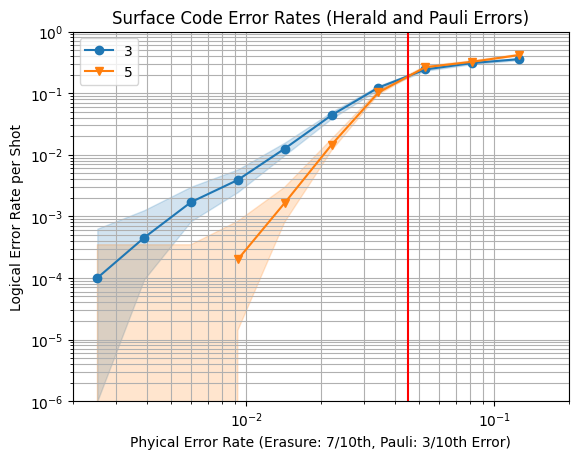

In [ ]:
e_and_p_stats_higher_e_frac = sinter.stats_from_csv_files('e_and_p_higher_e_fraction.csv')
pd_e_and_p = pd.read_csv('e_and_p_higher_e_fraction.csv')

# Render a matplotlib plot of the data.
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=e_and_p_stats_higher_e_frac,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d']
)

plt.xlim(2e-3,2e-1)
plt.ylim(1e-6,1)
ax.loglog()
ax.set_title("Surface Code Error Rates (Herald and Pauli Errors)")
ax.set_xlabel("Phyical Error Rate (Erasure: 7/10th, Pauli: 3/10th Error)")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.vlines(4.5e-2, 1e-9, 1, "red")
ax.legend()

In [79]:
! sinter combine higher_e_fraction_pauli.csv > combined_higher_e_fraction_pauli.csv
! sinter combine higher_e_fraction_erasure.csv > combined_higher_e_fraction_erasure.csv

In [80]:

e_collected_stats = sinter.stats_from_csv_files("combined_higher_e_fraction_erasure.csv")
p_collected_stats = sinter.stats_from_csv_files("combined_higher_e_fraction_pauli.csv")

pd_e = pd.read_csv("combined_higher_e_fraction_erasure.csv")
pd_p = pd.read_csv("combined_higher_e_fraction_pauli.csv")

pd_merged = pd_e


pd_merged['    errors'] = pd_e['    errors'] + pd_p['    errors']
pd_merged['     shots'] = pd_e['     shots'] + pd_p['     shots']

pd_merged.to_csv('e_and_p_higher_e_fraction.csv')

In [77]:
import scipy.stats as st

In [1]:
e_and_p_stats_higher_e_frac = sinter.stats_from_csv_files('e_and_p_higher_e_fraction.csv')
pd_e_and_p = pd.read_csv('e_and_p_higher_e_fraction.csv')

# Render a matplotlib plot of the data.
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=e_and_p_stats_higher_e_frac,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d']
)

plt.xlim(2e-3,2e-1)
plt.ylim(1e-6,1)
ax.loglog()
ax.set_title("Surface Code Error Rates (Herald and Pauli Errors)")
ax.set_xlabel("Phyical Error Rate (Erasure: 7/10th, Pauli: 3/10th Error)")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.vlines(4.5e-2, 1e-9, 1, "red")
ax.legend()

NameError: name 'sinter' is not defined

(np.float64(0.0174241706964511), np.float64(0.0225758293035489))

(1e-05, 1)

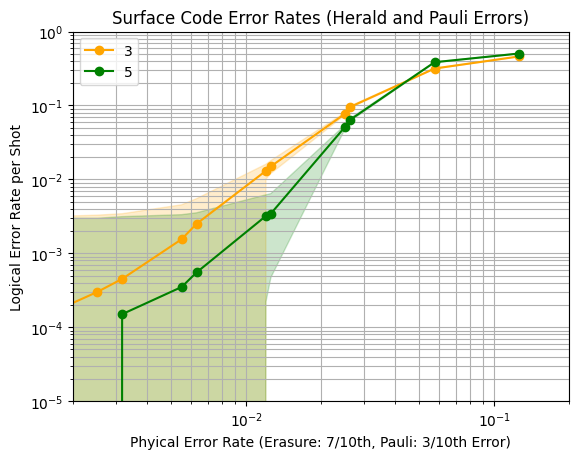

In [57]:
plot_new_error(e_and_p_stats_higher_e_frac)
plt.xlim(2e-3,2e-1)
plt.ylim(1e-5,1)

# Effect of altering cluster node size


In [11]:
err_list_size = 6
d_list_size = 2
depol_factor = 3/10
bf_factor = 1/10

err_list = np.logspace(-2.6,-0.9,err_list_size)
d_list = [3, 5, 9, 11]
cluster_size_list = [10, 50, 100, 500, 1000, 10**4]



def generate_circuits():
    pauli_circ_list = []
    erasure_circuit_list = []
    p = 1.5e-2
    for d in d_list:
        for cluster in cluster_size_list:
            erasure_circuit_list.append(rewriter(d, 
                                                p, 
                                                0,
                                                0,
                                                is_z_or_x = 'z',
                                                input_file = 'rotated_memory_z',
                                                output_file = f'cluster_error_{d}_{p}_{cluster}')['circuit'])

    return erasure_circuit_list

cs_circ_list = generate_circuits()

def generate_example_tasks(circ_list, cluster_size_list):
    t = 0
    p = 1.5e-2
    for d in d_list:
        for cluster in cluster_size_list:
            yield sinter.Task(
                circuit=circ_list[t],
                json_metadata={
                    'p': p,
                    'd': d,
                    'cluster': cluster
                },
            )
            t += 1




cs_collected_stats = list()
t = 0
cs = len(cluster_size_list)
for task in generate_example_tasks(cs_circ_list, cluster_size_list):
    task = [task]
    circ = cs_circ_list[t]
    #print(circ)
    collected_stat: List[sinter.TaskStats] = sinter.collect(
        num_workers=5,
        tasks=task,
        decoders=['mwpf'],
        custom_decoders = { "mwpf": SinterMWPFDecoder(cluster_node_limit=cluster_size_list[t % cs]).with_circuit(circ) },
        max_shots=int(10**(3)),
        max_errors=int(10**(3)),
        # count_detection_events=True,
        hint_num_tasks = err_list_size*d_list_size,
        save_resume_filepath = "cluster_error.csv",
        print_progress = True
        )
    cs_collected_stats = cs_collected_stats + collected_stat
    t+=1




fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=cs_collected_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['cluster'],
)
# ax.set_ylim(5e-6, 1e-1)
# ax.set_xlim(5e-6, 2e-1)
ax.loglog()
ax.set_title("Error Rates based on cluster size")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120) 





Starting 5 workers...
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata         
        5    mwpf <1m        999        1000 p=0.015,d=3,cluster=10
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata         
        5    mwpf <1m        983         999 p=0.015,d=3,cluster=10
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata         
        5    mwpf <1m        800         989 p=0.015,d=3,cluster=10
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata         
        5    mwpf <1m        783         989 p=0.015,d=3,cluster=10
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata         
        5    mwpf <1m        600         976 p=0.015,d=3,cluster=10
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata         
        5    mwpf <1m        400         948 p=0.015,d=3,cluster=10
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata      

: 

: 

# Finding Lambda

In [13]:


def make_lambda_circuit(distance, p, depol_factor, bf_factor, is_z_or_x, input_file_name, rounds):
    surface_code_circuit = stim.Circuit.generated(
        f"surface_code:rotated_memory_{is_z_or_x}",
        rounds=rounds,
        distance=distance,
        after_clifford_depolarization=p*depol_factor,
        after_reset_flip_probability=p*bf_factor,
        before_measure_flip_probability=p*bf_factor,
        before_round_data_depolarization=p*depol_factor)

    surface_code_circuit.to_file(input_file_name)
    

    
        
def count_erase_qubits(line, erase_qubits):
    erase_qubits.append(int(line[-3:-1]))
    return erase_qubits



def fix_non_erase_detector(line, erase_size, herald_count):
    rec_sect = re.findall(r"rec.+]", line)
    det_sect = re.findall(r"^rec.+]", line)
    digs = re.findall(r"-\d+", line)
    digs = [int(i) for i in digs]
    # print(det_sect)
    # print(rec_sect)
    
    digs_len = len(digs)
    new_digs = []
    if digs_len == 1:
        new_digs.append(digs[0] - erase_size)
    if digs_len == 2:
        new_digs.append(digs[0] - erase_size)
        new_digs.append(digs[1] - (herald_count+1)*(erase_size))
    if digs_len >= 3:
        for i in range(digs_len-1):
            new_digs.append(digs[i] - erase_size)
        new_digs.append(digs[-1] - 2*erase_size)
    new_rec_sect = ""
    # print(new_digs)
    for d in new_digs:
        new_rec_sect = new_rec_sect + f"rec[{d}] "

    new_line = re.sub(r"rec.+]", new_rec_sect, line)

    return new_line
  


def fix_observable(line, erase_size):
    rec_sect = re.findall(r"rec.+]", line)
    obs_sect = re.findall(r"^rec.+]", line)
    digs = re.findall(r"-\d+", line)
    digs = [int(i) for i in digs]
    
    digs_len = len(digs)
    new_digs = []

    for i in range(digs_len):
        new_digs.append(digs[i] - erase_size)
        
    new_rec_sect = ""
    # print(new_digs)
    for d in new_digs:
        new_rec_sect = new_rec_sect + f"rec[{d}] "

    new_line = re.sub(r"rec.+]", new_rec_sect, line)

    return new_line


def add_erasures(out_file, p: float, erase_qubits: list, indent, herald_count):
    if indent == True:
        out_file.write(f'\t')
    out_file.write(f'HERALDED_ERASE({p}) ')
    herald_count += 1
    for i in erase_qubits:
        out_file.write(f'{i} ')
    out_file.write('\n')
    return herald_count


def lambda_rewriter(distance:int, 
                    rounds: int,
                    error_in: float, 
                    depol_factor: float, 
                    bf_factor: float,
                    is_z_or_x:str,
                    input_file:str,
                    output_file:str,
                    erase_factor = 1):
    
    make_lambda_circuit(distance, error_in, depol_factor, bf_factor, is_z_or_x, input_file, rounds)

    erase_qubits = []
    herald_count_e = 0
    herald_count_m = 0
    indent = False
    meas_count = 0
    p = error_in * erase_factor

    
    
    
    with open(input_file) as in_file, open(output_file, 'w') as out_file:

        for line in in_file:
            # print("meas_count", meas_count)
            erase_qubit_len = len(erase_qubits)
            num_meas = int((erase_qubit_len - 1)/2)
            num_meas_2 = int((erase_qubit_len + 1)/2)
            # print(num_meas_2)
            # print(herald_count_e, herald_count_m)

            while "DETECTOR(" in line:
                #print("herald count now", herald_count_m)
                new_line = fix_non_erase_detector(line, erase_qubit_len, herald_count_m)
                out_file.write(new_line)
                line = next(in_file)
                
                if "DETECTOR(" not in line:
                    herald_count_m = 0

            while line.startswith("QUBIT"):
                erase_qubits = count_erase_qubits(line, erase_qubits)
                out_file.write(line)
                line = next(in_file)

            if "OBSERVABLE" in line:
                new_line = fix_observable(line, erase_qubit_len)
                out_file.write(new_line)
                break

            
            out_file.write(line)

            if "{" in line:
                indent = True
            elif "}" in line:
                indent = False

            if ("TICK" in line):
                # ADD HERALD
                herald_count_e=add_erasures(out_file, p, erase_qubits, indent, herald_count_e)
                herald_count_m = herald_count_e
                meas_count += herald_count_e*erase_qubit_len
            
            if ('M' in line):
                # ADD HERALD
                herald_count_e=add_erasures(out_file, p, erase_qubits, indent, herald_count_e)
                herald_count_m = herald_count_e
                #print(herald_count_e)
                meas_count += herald_count_m*erase_qubit_len
                # ADD DETECTORS
                if ('MR' in line):
                    # print("meas_count mr", meas_count)
                    meas_count+=num_meas
                    detector_list = range(1, herald_count_e*erase_qubit_len + 1)
                    # print(detector_list )
                    # print("herald count", herald_count_e)
                    for det in detector_list:
                        if indent == True:
                            out_file.write(f'\t')
                        
                        if det > erase_qubit_len:
                            out_file.write(f'DETECTOR rec[-{det + num_meas}]\n')
                            
                        else:
                            out_file.write(f'DETECTOR rec[-{det}]\n')
                            
                else:
                    # print("meas_count m", meas_count)
                    meas_count+= num_meas_2
                    detector_list = range(1, erase_qubit_len + 1)
                    # print(detector_list )
                    for det in detector_list:
                        if indent == True:
                            out_file.write(f'\t')
                       
                        if det > erase_qubit_len:
                            out_file.write(f'DETECTOR rec[-{det + num_meas_2}]\n')
                            
                        else:
                            out_file.write(f'DETECTOR rec[-{det}]\n')
                            

                
                
                herald_count_e = 0
                

            

            

    c = stim.Circuit.from_file(output_file)
    #print(c.num_detectors)

    if os.path.isfile(output_file):
        os.remove(output_file)

    dem = mwpf.heralded_dem.HeraldedDetectorErrorModel.of(c)

    c = mwpf.heralded_dem.add_herald_detectors(c)


    return {'circuit':c ,'dem': dem}
    

In [11]:
err_list_size = 6
d_list_size = 2
depol_factor = 3/10
bf_factor = 1/10

err_list = np.logspace(-2.6,-0.9,err_list_size)
d_list = [3, 5,7]
rep_list = list(range(2,20, 4))



def generate_circuits():
    pauli_circ_list = []
    erasure_circuit_list = []
    p = 1e-2
    for r in rep_list:
        for d in d_list:
            erasure_circuit_list.append(lambda_rewriter(d, 
                                    r,
                                    p, 
                                    0,
                                    0,
                                    is_z_or_x = 'z',
                                    input_file = 'rotated_memory_z',
                                    output_file = f'lambda_calc_{d}_{p}_{r}_erase')['circuit'])
            pauli_circ_list.append(lambda_rewriter(d, 
                                    r,
                                    p, 
                                    depol_factor,
                                    bf_factor,
                                    is_z_or_x = 'z',
                                    input_file = 'rotated_memory_z',
                                    output_file = f'lambda_calc_{d}_{p}_{r}_pauli',
                                    erase_factor=0)['circuit'])
    return erasure_circuit_list, pauli_circ_list

erasure_circ_list, pauli_circ_list = generate_circuits()

def generate_example_tasks(circ_list):
    t = 0
    p = 1e-2
    for r in rep_list:
        for d in d_list:
            yield sinter.Task(
                circuit=circ_list[t],
                json_metadata={
                    'p': p,
                    'd': d,
                    'r': r,
                },
            )
            t += 1




e_collected_stats = list()
t = 0
for task in generate_example_tasks(erasure_circ_list):
    task = [task]
    circ = erasure_circ_list[t]
    #print(circ)
    
    collected_stat: List[sinter.TaskStats] = sinter.collect(
        num_workers=10,
        tasks=task,
        decoders=['mwpf'],
        custom_decoders = { "mwpf": SinterMWPFDecoder(cluster_node_limit=500).with_circuit(circ) },
        max_shots=int(10**(3)),
        max_errors=int(10**(3)),
        # count_detection_events=True,
        hint_num_tasks = err_list_size*d_list_size,
        save_resume_filepath = "lambda_calc_erasure.csv",
        print_progress = True
        )
    e_collected_stats = e_collected_stats + collected_stat
    t+=1

p_collected_stats = list()
t = 0
for task in generate_example_tasks(pauli_circ_list):
    task = [task]
    #print(circ)
    collected_stat: List[sinter.TaskStats] = sinter.collect(
        num_workers=5,
        tasks=task,
        decoders=['pymatching'],
        max_shots=int(10**(4)),
        max_errors=int(10**(4)),
        # count_detection_events=True,
        hint_num_tasks = err_list_size*d_list_size,
        save_resume_filepath = "lambda_calc_pauli.csv",
        print_progress = True
        )
    p_collected_stats = p_collected_stats + collected_stat
    t+=1








KeyboardInterrupt: 

## lambda worst case

In [ ]:
err_list_size = 6
d_list_size = 2
depol_factor = 3/10
bf_factor = 1/10

err_list = np.logspace(-2.6,-0.9,err_list_size)
d_list = [3, 5, 7]
rep_list = list(range(15,20, 1))



def generate_circuits():
    pauli_circ_list = []
    erasure_circuit_list = []
    p = 5.5e-3
    for r in rep_list:
        for d in d_list:
            erasure_circuit_list.append(lambda_rewriter(d, 
                                    r,
                                    p, 
                                    0,
                                    0,
                                    is_z_or_x = 'z',
                                    input_file = 'rotated_memory_z',
                                    output_file = f'lambda_calc_{d}_{p}_{r}_erase')['circuit'])
            pauli_circ_list.append(lambda_rewriter(d, 
                                    r,
                                    p, 
                                    depol_factor,
                                    bf_factor,
                                    is_z_or_x = 'z',
                                    input_file = 'rotated_memory_z',
                                    output_file = f'lambda_calc_{d}_{p}_{r}_pauli',
                                    erase_factor=0)['circuit'])
    return erasure_circuit_list, pauli_circ_list

erasure_circ_list, pauli_circ_list = generate_circuits()

def generate_example_tasks(circ_list):
    t = 0
    p = 5.5e-3
    for r in rep_list:
        for d in d_list:
            yield sinter.Task(
                circuit=circ_list[t],
                json_metadata={
                    'p': p,
                    'd': d,
                    'r': r,
                },
            )
            t += 1




e_collected_stats = list()
t = 0
for task in generate_example_tasks(erasure_circ_list):
    task = [task]
    circ = erasure_circ_list[t]
    #print(circ)
    
    collected_stat: List[sinter.TaskStats] = sinter.collect(
        num_workers=12,
        tasks=task,
        decoders=['mwpf'],
        custom_decoders = { "mwpf": SinterMWPFDecoder(cluster_node_limit=50).with_circuit(circ) },
        max_shots=int(10**(3)),
        max_errors=int(10**(3)),
        # count_detection_events=True,
        hint_num_tasks = err_list_size*d_list_size,
        save_resume_filepath = "lambda_calc_erasure_worst_case.csv",
        print_progress = True
        )
    e_collected_stats = e_collected_stats + collected_stat
    t+=1

p_collected_stats = list()
t = 0
for task in generate_example_tasks(pauli_circ_list):
    task = [task]
    #print(circ)
    # circ = pauli_circ_list[t]
    collected_stat: List[sinter.TaskStats] = sinter.collect(
        num_workers=5,
        tasks=task,
        decoders=['pymatching'],
        max_shots=int(10**(4)),
        max_errors=int(10**(4)),
        # count_detection_events=True,
        hint_num_tasks = err_list_size*d_list_size,
        save_resume_filepath = "lambda_calc_pauli_worst_case.csv",
        print_progress = True
        )
    p_collected_stats = p_collected_stats + collected_stat
    t+=1








Starting 12 workers...
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata    
       12    mwpf <1m        999        1000 p=0.0055,d=3,r=15
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata    
       12    mwpf <1m        965        1000 p=0.0055,d=3,r=15
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata    
       12    mwpf <1m        916        1000 p=0.0055,d=3,r=15
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata    
       12    mwpf <1m        915        1000 p=0.0055,d=3,r=15
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata    
       12    mwpf <1m        840         999 p=0.0055,d=3,r=15
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata    
       12    mwpf <1m        839         999 p=0.0055,d=3,r=15
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata    
       12    mwpf <1m        809         998 p=0.0055,d=3,r=

In [ ]:
! sinter combine lambda_calc_erasure_worst_case.csv > combined_lambda_calc_erasure_worst_case.csv
! sinter combine lambda_calc_pauli_worst_case.csv > combined_lambda_calc_pauli_worst_case.csv

In [ ]:


pd_lambda_e = pd.read_csv("combined_lambda_calc_erasure_worst_case.csv")
pd_lambda_p = pd.read_csv("combined_lambda_calc_pauli_worst_case.csv")

pd_lambda_merged = pd_lambda_e


pd_lambda_merged['    errors'] = 10* pd_lambda_e['    errors'] + pd_lambda_p['    errors']
pd_lambda_merged['     shots'] = 10* pd_lambda_e['     shots'] + pd_lambda_p['     shots']

pd_lambda_merged.to_csv('e_and_p_lambda.csv')

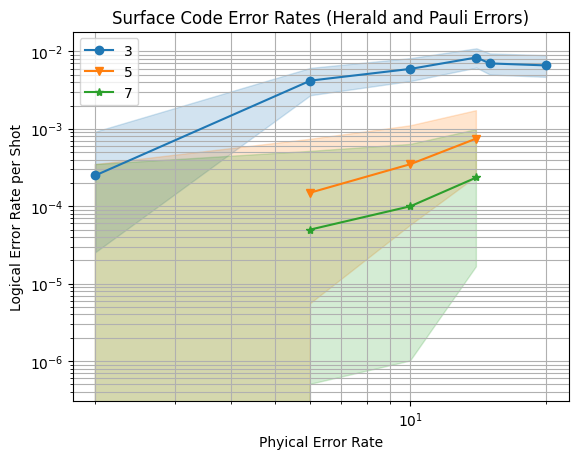

In [33]:
e_and_p_lambda = sinter.stats_from_csv_files('e_and_p_lambda.csv')


# Render a matplotlib plot of the data.
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=e_and_p_lambda,
    x_func=lambda stats: stats.json_metadata['r'],
    group_func=lambda stats: stats.json_metadata['d'],
)
ax.loglog()
ax.set_title("Surface Code Error Rates (Herald and Pauli Errors)")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()

[[Model]]
    Model(lb)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 99
    # data points      = 3
    # variables        = 2
    chi-square         = 4.9178e-11
    reduced chi-square = 4.9178e-11
    Akaike info crit   = -70.5025479
    Bayesian info crit = -72.3053233
    R-squared          = 0.99963665
[[Variables]]
    l:  0.06241496 +/- 0.01487155 (23.83%) (init = 0.5)
    a:  0.12034574 +/- 0.05748975 (47.77%) (init = 0.001)
[[Correlations]] (unreported correlations are < 0.100)
    C(l, a) = -0.9995
Lambda of non-erasure surface code is 16.021800929769775


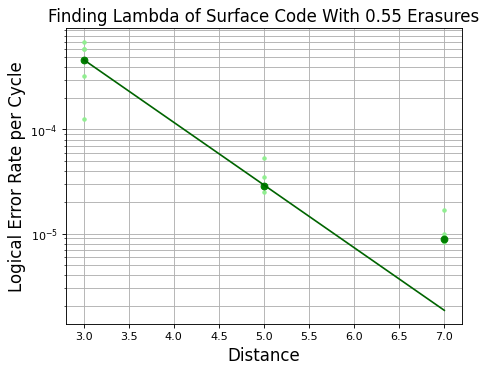

In [41]:
def lb(d, l,a):
    y = a*(l)**(((d+1)/2)) 
    return y


collected_stats = sinter.stats_from_csv_files('e_and_p_lambda.csv')

xs = [(stat.json_metadata['d']) for stat in collected_stats]
ys = [(stat.errors/stat.shots/stat.json_metadata['r']) for stat in collected_stats]




group_func=lambda stats: stats.json_metadata['d']
grouped_stats = sinter.group_by(collected_stats, key = group_func)

mean_y_list = []
group_y_list = []
for d in grouped_stats:
    grouped_ys = [(stat.errors/stat.shots/stat.json_metadata['r']) for stat in grouped_stats[d]]
    group_y_list.append(grouped_ys)
    mean_y_list.append(np.mean(grouped_ys))


fig, ax = plt.subplots(1, 1)
plt.plot(xs,ys, ".", color = "lightgreen")
plt.plot(grouped_stats.keys() , mean_y_list, "o", color = "green")


# linear_model = Model(linear)
# params = linear_model.make_params()

lb_model = Model(lb)
# lb_model.set_param_hint('a', min=0.5, max = 10)
params = lb_model.make_params()

result = lb_model.fit(mean_y_list, 
                                 d=list(grouped_stats.keys() ), 
                                 l = 0.5,
                                 a = 0.001
                                 )

# result = lb_model.fit(ys, 
#                                  d=list(xs), 
#                                  l = 0.5,
#                                  )

print(result.fit_report())



#plt.plot(grouped_stats.keys(), result.init_fit, '--', label='initial fit')
plt.plot(grouped_stats.keys(), result.best_fit, '-', label='best fit', color = "darkgreen")

l = result.best_values['l']
a = result.best_values['a']

d_3 = lb(3, l, a)
d_5 = lb(5, l, a)
d_7 = lb(7, l, a)


print(f"Lambda of non-erasure surface code is {np.mean([d_3/d_5, d_5/d_7])}")

ax.set_yscale('log')
plt.rc('axes', titlesize = 15)
plt.rc('axes', labelsize = 15)
plt.xlabel("Distance")
plt.ylabel("Logical Error Rate per Cycle")
ax.grid(which='major')
ax.grid(which='minor')
plt.title("Finding Lambda of Surface Code With 0.55 Erasures")
fig.set_dpi(80) 

## lambda 7/10 erasure

In [43]:
d_list_size = 3
d_list = [3, 5, 7]
rep_list = list(range(2,16, 3))

erase_factor = 7/10
depol_factor = (((1 - erase_factor)/4) * 3) / 2
bf_factor = (((1 - erase_factor)/4)) / 2



def generate_circuits():
    pauli_circ_list = []
    erasure_circuit_list = []
    p = 1e-2
    for r in rep_list:
        for d in d_list:
            erasure_circuit_list.append(lambda_rewriter(d, 
                                    r,
                                    p, 
                                    0,
                                    0,
                                    is_z_or_x = 'z',
                                    input_file = 'rotated_memory_z',
                                    output_file = f'lambda_calc_{d}_{p}_{r}_erase',
                                    erase_factor = erase_factor)['circuit'])
            pauli_circ_list.append(lambda_rewriter(d, 
                                    r,
                                    p, 
                                    depol_factor,
                                    bf_factor,
                                    is_z_or_x = 'z',
                                    input_file = 'rotated_memory_z',
                                    output_file = f'lambda_calc_{d}_{p}_{r}_pauli',
                                    erase_factor=0)['circuit'])
    return erasure_circuit_list, pauli_circ_list

erasure_circ_list, pauli_circ_list = generate_circuits()

def generate_example_tasks(circ_list):
    t = 0
    p = 1e-2
    for r in rep_list:
        for d in d_list:
            yield sinter.Task(
                circuit=circ_list[t],
                json_metadata={
                    'p': p,
                    'd': d,
                    'r': r,
                },
            )
            t += 1




e_collected_stats = list()
t = 0
for task in generate_example_tasks(erasure_circ_list):
    task = [task]
    circ = erasure_circ_list[t]
    #print(circ)
    
    collected_stat: List[sinter.TaskStats] = sinter.collect(
        num_workers=12,
        tasks=task,
        decoders=['mwpf'],
        custom_decoders = { "mwpf": SinterMWPFDecoder(cluster_node_limit=50).with_circuit(circ) },
        max_shots=int(10**(4)),
        max_errors=int(10**(4)),
        # count_detection_events=True,
        hint_num_tasks = 20*d_list_size,
        save_resume_filepath = "lambda_calc_seventy_percent_erasure_worst_case.csv",
        print_progress = True
        )
    e_collected_stats = e_collected_stats + collected_stat
    t+=1

p_collected_stats = list()
t = 0
for task in generate_example_tasks(pauli_circ_list):
    task = [task]
    #print(circ)
    # circ = pauli_circ_list[t]
    collected_stat: List[sinter.TaskStats] = sinter.collect(
        num_workers=5,
        tasks=task,
        decoders=['pymatching'],
        max_shots=int(10**(4)),
        max_errors=int(10**(4)),
        # count_detection_events=True,
        hint_num_tasks = 20*d_list_size,
        save_resume_filepath = "lambda_calc_seventy_percent_pauli_worst_case.csv",
        print_progress = True
        )
    p_collected_stats = p_collected_stats + collected_stat
    t+=1








Starting 12 workers...
Starting 12 workers...
Starting 12 workers...
Starting 12 workers...
Starting 12 workers...
Starting 12 workers...
Starting 12 workers...
Starting 12 workers...
Starting 12 workers...
Starting 12 workers...
Starting 12 workers...
Starting 12 workers...
Starting 12 workers...
Starting 12 workers...
Starting 12 workers...


RuntimeError: Worker failed: traceback=Traceback (most recent call last):
  File "c:\Users\diyan\anaconda3\envs\simulation\Lib\site-packages\sinter\_collection\_collection_worker_state.py", line 243, in run_message_loop
    num_messages_processed = self.process_messages()
                             ^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\diyan\anaconda3\envs\simulation\Lib\site-packages\sinter\_collection\_collection_worker_state.py", line 182, in process_messages
    self.change_job(new_task=new_task, new_collection_options=new_collection_options)
  File "c:\Users\diyan\anaconda3\envs\simulation\Lib\site-packages\sinter\_collection\_collection_worker_state.py", line 145, in change_job
    self.compiled_sampler = self.sampler.compiled_sampler_for_task(self.current_task)
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\diyan\anaconda3\envs\simulation\Lib\site-packages\sinter\_collection\_sampler_ramp_throttled.py", line 27, in compiled_sampler_for_task
    compiled_sub_sampler = self.sub_sampler.compiled_sampler_for_task(task)
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\diyan\anaconda3\envs\simulation\Lib\site-packages\sinter\_collection\_mux_sampler.py", line 30, in compiled_sampler_for_task
    return self._resolve_sampler(task.decoder).compiled_sampler_for_task(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\diyan\anaconda3\envs\simulation\Lib\site-packages\sinter\_decoding\_stim_then_decode_sampler.py", line 40, in compiled_sampler_for_task
    return _CompiledStimThenDecodeSampler(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\diyan\anaconda3\envs\simulation\Lib\site-packages\sinter\_decoding\_stim_then_decode_sampler.py", line 161, in __init__
    self.compiled_decoder = _compile_decoder_with_disk_fallback(decoder, task, tmp_dir)
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\diyan\anaconda3\envs\simulation\Lib\site-packages\sinter\_decoding\_stim_then_decode_sampler.py", line 142, in _compile_decoder_with_disk_fallback
    return decoder.compile_decoder_for_dem(dem=task.detector_error_model)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\diyan\anaconda3\envs\simulation\Lib\site-packages\mwpf\sinter_decoders.py", line 180, in compile_decoder_for_dem
    solver, predictor, bp_decoder = self.common_prepare(dem)
                                    ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\diyan\anaconda3\envs\simulation\Lib\site-packages\mwpf\sinter_decoders.py", line 130, in common_prepare
    solver, predictor = construct_decoder_and_predictor(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\diyan\anaconda3\envs\simulation\Lib\site-packages\mwpf\sinter_decoders.py", line 290, in construct_decoder_and_predictor
    initializer = heralded_dem.initializer
                  ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\diyan\anaconda3\envs\simulation\Lib\functools.py", line 998, in __get__
    val = self.func(instance)
          ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\diyan\anaconda3\envs\simulation\Lib\site-packages\mwpf\heralded_dem.py", line 305, in initializer
    for dic in self.herald_fault_map
               ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\diyan\anaconda3\envs\simulation\Lib\functools.py", line 998, in __get__
    val = self.func(instance)
          ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\diyan\anaconda3\envs\simulation\Lib\site-packages\mwpf\heralded_dem.py", line 276, in herald_fault_map
    if detector not in self.heralded_dems:
                       ^^^^^^^^^^^^^^^^^^
  File "c:\Users\diyan\anaconda3\envs\simulation\Lib\functools.py", line 998, in __get__
    val = self.func(instance)
          ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\diyan\anaconda3\envs\simulation\Lib\site-packages\mwpf\heralded_dem.py", line 209, in heralded_dems
    circuit_no_noise = self.ref_circuit.remove_noise_channels(
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\diyan\anaconda3\envs\simulation\Lib\site-packages\mwpf\ref_circuit.py", line 451, in remove_noise_channels
    assert len(set(deleting_indices)) == len(deleting_indices), "bug: duplicate"
               ^^^^^^^^^^^^^^^^^^^^^
MemoryError


[2, 5, 8, 11, 14]

In [14]:
d_list_size = 3
d_list = [3, 5, 7]
rep_list = list(range(2,16, 3))

erase_factor = 7/10
depol_factor = (((1 - erase_factor)/4) * 3) / 2
bf_factor = (((1 - erase_factor)/4)) / 2



def generate_circuits():
    pauli_circ_list = []
    erasure_circuit_list = []
    p = 1e-2
    for r in rep_list:
        for d in d_list:
            erasure_circuit_list.append(lambda_rewriter(d, 
                                    r,
                                    p, 
                                    0,
                                    0,
                                    is_z_or_x = 'z',
                                    input_file = 'rotated_memory_z',
                                    output_file = f'lambda_calc_{d}_{p}_{r}_erase',
                                    erase_factor = erase_factor)['circuit'])
            pauli_circ_list.append(lambda_rewriter(d, 
                                    r,
                                    p, 
                                    depol_factor,
                                    bf_factor,
                                    is_z_or_x = 'z',
                                    input_file = 'rotated_memory_z',
                                    output_file = f'lambda_calc_{d}_{p}_{r}_pauli',
                                    erase_factor=0)['circuit'])
    return erasure_circuit_list, pauli_circ_list

erasure_circ_list, pauli_circ_list = generate_circuits()

def generate_example_tasks(circ_list):
    t = 0
    p = 1e-2
    for r in rep_list:
        for d in d_list:
            yield sinter.Task(
                circuit=circ_list[t],
                json_metadata={
                    'p': p,
                    'd': d,
                    'r': r,
                },
            )
            t += 1




# e_collected_stats = list()
# t = 0
# for task in generate_example_tasks(erasure_circ_list):
#     task = [task]
#     circ = erasure_circ_list[t]
#     #print(circ)
    
#     collected_stat: List[sinter.TaskStats] = sinter.collect(
#         num_workers=12,
#         tasks=task,
#         decoders=['mwpf'],
#         custom_decoders = { "mwpf": SinterMWPFDecoder(cluster_node_limit=50).with_circuit(circ) },
#         max_shots=int(10**(4)),
#         max_errors=int(10**(4)),
#         # count_detection_events=True,
#         hint_num_tasks = 20*d_list_size,
#         save_resume_filepath = "lambda_calc_seventy_percent_erasure_worst_case.csv",
#         print_progress = True
#         )
#     e_collected_stats = e_collected_stats + collected_stat
#     t+=1

p_collected_stats = list()
t = 0
for task in generate_example_tasks(pauli_circ_list):
    task = [task]
    #print(circ)
    # circ = pauli_circ_list[t]
    collected_stat: List[sinter.TaskStats] = sinter.collect(
        num_workers=5,
        tasks=task,
        decoders=['pymatching'],
        max_shots=int(10**(4)),
        max_errors=int(10**(4)),
        # count_detection_events=True,
        hint_num_tasks = 20*d_list_size,
        save_resume_filepath = "lambda_calc_seventy_percent_pauli_worst_case.csv",
        print_progress = True
        )
    p_collected_stats = p_collected_stats + collected_stat
    t+=1








Starting 5 workers...
1 tasks left:
  workers    decoder eta shots_left errors_left json_metadata 
        5 pymatching   ?       8000       10000 p=0.01,d=3,r=2
1 tasks left:
  workers    decoder eta shots_left errors_left json_metadata 
        5 pymatching   ?       2000        9994 p=0.01,d=3,r=2
0 tasks left:

Starting 5 workers...
1 tasks left:
  workers    decoder eta shots_left errors_left json_metadata 
        5 pymatching <1m       8000       10000 p=0.01,d=5,r=2
1 tasks left:
  workers    decoder eta shots_left errors_left json_metadata 
        5 pymatching <1m       2000       10000 p=0.01,d=5,r=2
1 tasks left:
  workers    decoder eta shots_left errors_left json_metadata 
        5 pymatching   ?          0       10000 p=0.01,d=5,r=2
Starting 5 workers...
1 tasks left:
  workers    decoder eta shots_left errors_left json_metadata 
        5 pymatching <1m       8703       10000 p=0.01,d=7,r=2
1 tasks left:
  workers    decoder eta shots_left errors_left json_metadata 
  

## lambda plot

In [44]:
! sinter combine lambda_calc_seventy_percent_erasure_worst_case.csv > combined_lambda_calc_seventy_erasure_worst_case.csv
! sinter combine lambda_calc_seventy_percent_pauli_worst_case.csv > combined_lambda_calc_seventy_pauli_worst_case.csv

In [45]:

pd_lambda_e = pd.read_csv("combined_lambda_calc_seventy_erasure_worst_case.csv")
pd_lambda_p = pd.read_csv( "combined_lambda_calc_seventy_pauli_worst_case.csv")

pd_lambda_merged = pd_lambda_e

# print(pd_lambda_e['json_metadata'].iloc[i])
# print(pd_lambda_p['json_metadata'].iloc[i])

for i in range(len(pd_lambda_merged)):
    if  pd_lambda_e['json_metadata'].iloc[i] == pd_lambda_p['json_metadata'].iloc[i]:
    
        if pd_lambda_e['     shots'].iloc[i] < 1000:
            
            continue

        rescaler = pd_lambda_p['     shots'].iloc[i] / pd_lambda_e['     shots'].iloc[i] 
        pd_lambda_merged.loc[i, '    errors'] = int(rescaler * pd_lambda_e['    errors'].iloc[i] + pd_lambda_p['    errors'].iloc[i])
        pd_lambda_merged.loc[i, '     shots']= int(rescaler * pd_lambda_e['     shots'].iloc[i] + pd_lambda_p['     shots'].iloc[i])

    else:
        print("ROWS NOT ALIGNED")
    



pd_lambda_merged.to_csv('e_and_p_seventy_lambda.csv')

[[Model]]
    Model(lb)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 158
    # data points      = 3
    # variables        = 2
    chi-square         = 1.8651e-18
    reduced chi-square = 1.8651e-18
    Akaike info crit   = -121.765506
    Bayesian info crit = -123.568281
    R-squared          = 1.00000000
[[Variables]]
    l:  0.03634217 +/- 2.5250e-06 (0.01%) (init = 0.5)
    a:  0.40869541 +/- 5.6838e-05 (0.01%) (init = 0.0001)
[[Correlations]] (unreported correlations are < 0.100)
    C(l, a) = -0.9998
Lambda of 7/10 erasure surface code is 27.516246341485957


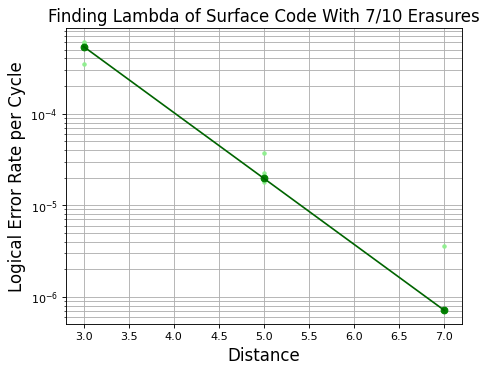

In [46]:
def lb(d, l,a):
    y = a*(l)**(((d+1)/2)) 
    return y


collected_stats = sinter.stats_from_csv_files('e_and_p_seventy_lambda.csv')

xs = [(stat.json_metadata['d']) for stat in collected_stats]
ys = [(stat.errors/stat.shots/stat.json_metadata['r']) for stat in collected_stats]




group_func=lambda stats: stats.json_metadata['d']
grouped_stats = sinter.group_by(collected_stats, key = group_func)

mean_y_list = []
group_y_list = []
for d in grouped_stats:
    grouped_ys = [(stat.errors/stat.shots/stat.json_metadata['r']) for stat in grouped_stats[d]]
    group_y_list.append(grouped_ys)
    mean_y_list.append(np.mean(grouped_ys))


fig, ax = plt.subplots(1, 1)
plt.plot(xs,ys, ".", color = "lightgreen")
plt.plot(grouped_stats.keys() , mean_y_list, "o", color = "green")


# linear_model = Model(linear)
# params = linear_model.make_params()

lb_model = Model(lb)
# lb_model.set_param_hint('a', min=0.5, max = 10)
params = lb_model.make_params()

result = lb_model.fit(mean_y_list, 
                                 d=list(grouped_stats.keys() ), 
                                 l = 0.5,
                                 a = 0.0001
                                 )

# result = lb_model.fit(ys, 
#                                  d=list(xs), 
#                                  l = 0.5,
#                                  )

print(result.fit_report())



#plt.plot(grouped_stats.keys(), result.init_fit, '--', label='initial fit')
plt.plot(grouped_stats.keys(), result.best_fit, '-', label='best fit', color = "darkgreen")

l = result.best_values['l']
a = result.best_values['a']

d_3 = lb(3, l, a)
d_5 = lb(5, l, a)
d_7 = lb(7, l, a)


print(f"Lambda of 7/10 erasure surface code is {np.mean([d_3/d_5, d_5/d_7])}")

ax.set_yscale('log')
plt.rc('axes', titlesize = 15)
plt.rc('axes', labelsize = 15)
plt.xlabel("Distance")
plt.ylabel("Logical Error Rate per Cycle")
ax.grid(which='major')
ax.grid(which='minor')
plt.title("Finding Lambda of Surface Code With 7/10 Erasures")
fig.set_dpi(80) 

### UF decoder

In [11]:
err_list_size = 6
d_list_size = 2
depol_factor = 3/10
bf_factor = 1/10

err_list = np.logspace(-2.6,-0.9,err_list_size)
d_list = [3, 5, 7]
rep_list = list(range(15,70, 10))



def generate_circuits():
    pauli_circ_list = []
    erasure_circuit_list = []
    p = 5.5e-3
    for r in rep_list:
        for d in d_list:
            erasure_circuit_list.append(lambda_rewriter(d, 
                                    r,
                                    p, 
                                    0,
                                    0,
                                    is_z_or_x = 'z',
                                    input_file = 'rotated_memory_z',
                                    output_file = f'lambda_calc_{d}_{p}_{r}_erase')['circuit'])
            pauli_circ_list.append(lambda_rewriter(d, 
                                    r,
                                    p, 
                                    depol_factor,
                                    bf_factor,
                                    is_z_or_x = 'z',
                                    input_file = 'rotated_memory_z',
                                    output_file = f'lambda_calc_{d}_{p}_{r}_pauli',
                                    erase_factor=0)['circuit'])
    return erasure_circuit_list, pauli_circ_list

erasure_circ_list, pauli_circ_list = generate_circuits()

def generate_example_tasks(circ_list):
    t = 0
    p = 5.5e-3
    for r in rep_list:
        for d in d_list:
            yield sinter.Task(
                circuit=circ_list[t],
                json_metadata={
                    'p': p,
                    'd': d,
                    'r': r,
                },
            )
            t += 1




e_collected_stats = list()
t = 0
for task in generate_example_tasks(erasure_circ_list):
    task = [task]
    circ = erasure_circ_list[t]
    #print(circ)
    
    collected_stat: List[sinter.TaskStats] = sinter.collect(
        num_workers=12,
        tasks=task,
        decoders=['mwpf'],
        custom_decoders = { "mwpf": SinterMWPFDecoder(cluster_node_limit=0).with_circuit(circ) },
        max_shots=int(10**(3)),
        max_errors=int(10**(3)),
        # count_detection_events=True,
        hint_num_tasks = err_list_size*d_list_size,
        save_resume_filepath = "lambda_calc_UF_erasure.csv",
        print_progress = True
        )
    e_collected_stats = e_collected_stats + collected_stat
    t+=1

p_collected_stats = list()
t = 0
for task in generate_example_tasks(pauli_circ_list):
    task = [task]
    #print(circ)
    # circ = pauli_circ_list[t]
    collected_stat: List[sinter.TaskStats] = sinter.collect(
        num_workers=5,
        tasks=task,
        decoders=['pymatching'],
        max_shots=int(10**(4)),
        max_errors=int(10**(4)),
        # count_detection_events=True,
        hint_num_tasks = err_list_size*d_list_size,
        save_resume_filepath = "lambda_calc_UF_pauli.csv",
        print_progress = True
        )
    p_collected_stats = p_collected_stats + collected_stat
    t+=1








Starting 12 workers...
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata    
       12    mwpf <1m        983        1000 p=0.0055,d=3,r=15
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata    
       12    mwpf <1m        916        1000 p=0.0055,d=3,r=15
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata    
       12    mwpf <1m        915        1000 p=0.0055,d=3,r=15
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata    
       12    mwpf <1m        840         999 p=0.0055,d=3,r=15
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata    
       12    mwpf <1m        833         999 p=0.0055,d=3,r=15
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata    
       12    mwpf <1m        756         997 p=0.0055,d=3,r=15
1 tasks left:
  workers decoder eta shots_left errors_left json_metadata    
       12    mwpf <1m        672         997 p=0.0055,d=3,r=

: 

: 

# non erased surface code

In [51]:
surface_code_circuit_big = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=15*3,
    distance=15,
    after_clifford_depolarization=0.001,
    after_reset_flip_probability=0.001,
    before_measure_flip_probability=0.001,
    before_round_data_depolarization=0.001)

print(surface_code_circuit_big)

QUBIT_COORDS(1, 1) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 1) 3
QUBIT_COORDS(5, 1) 5
QUBIT_COORDS(6, 0) 6
QUBIT_COORDS(7, 1) 7
QUBIT_COORDS(9, 1) 9
QUBIT_COORDS(10, 0) 10
QUBIT_COORDS(11, 1) 11
QUBIT_COORDS(13, 1) 13
QUBIT_COORDS(14, 0) 14
QUBIT_COORDS(15, 1) 15
QUBIT_COORDS(17, 1) 17
QUBIT_COORDS(18, 0) 18
QUBIT_COORDS(19, 1) 19
QUBIT_COORDS(21, 1) 21
QUBIT_COORDS(22, 0) 22
QUBIT_COORDS(23, 1) 23
QUBIT_COORDS(25, 1) 25
QUBIT_COORDS(26, 0) 26
QUBIT_COORDS(27, 1) 27
QUBIT_COORDS(29, 1) 29
QUBIT_COORDS(1, 3) 32
QUBIT_COORDS(2, 2) 33
QUBIT_COORDS(3, 3) 34
QUBIT_COORDS(4, 2) 35
QUBIT_COORDS(5, 3) 36
QUBIT_COORDS(6, 2) 37
QUBIT_COORDS(7, 3) 38
QUBIT_COORDS(8, 2) 39
QUBIT_COORDS(9, 3) 40
QUBIT_COORDS(10, 2) 41
QUBIT_COORDS(11, 3) 42
QUBIT_COORDS(12, 2) 43
QUBIT_COORDS(13, 3) 44
QUBIT_COORDS(14, 2) 45
QUBIT_COORDS(15, 3) 46
QUBIT_COORDS(16, 2) 47
QUBIT_COORDS(17, 3) 48
QUBIT_COORDS(18, 2) 49
QUBIT_COORDS(19, 3) 50
QUBIT_COORDS(20, 2) 51
QUBIT_COORDS(21, 3) 52
QUBIT_COORDS(22, 2) 53
QUBIT_COORD

In [25]:
surface_code_tasks = [
    sinter.Task(
        circuit = stim.Circuit.generated(
            "surface_code:rotated_memory_z",
            rounds=d * 3,
            distance=d,
            after_clifford_depolarization=noise*depol_factor,
            after_reset_flip_probability=noise*bf_factor,
            before_measure_flip_probability=noise*bf_factor,
            before_round_data_depolarization=noise*depol_factor,
        ),
        json_metadata={'d': d, 'r': d * 3, 'p': noise},
    )
    for d in [3, 5]
    for noise in np.logspace(-3,-1, 10)
]

collected_surface_code_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=4,
    tasks=surface_code_tasks,
    decoders=['pymatching'],
    max_shots=10**(4),
    max_errors=10**(4),
    print_progress=True,
)

Starting 4 workers...
20 tasks left:
  workers    decoder eta shots_left errors_left json_metadata                   
        1 pymatching   ?      10000       10000 d=3,r=9,p=0.001                 
        1 pymatching  3m       9999       10000 d=3,r=9,p=0.0016681005372000592 
        1 pymatching   ?      10000       10000 d=3,r=9,p=0.0027825594022071257 
        1 pymatching   ?      10000       10000 d=3,r=9,p=0.004641588833612777  
        0 pymatching ?·∞      10000       10000 d=3,r=9,p=0.007742636826811269  
        0 pymatching ?·∞      10000       10000 d=3,r=9,p=0.01291549665014884   
        0 pymatching ?·∞      10000       10000 d=3,r=9,p=0.021544346900318832  
        0 pymatching ?·∞      10000       10000 d=3,r=9,p=0.03593813663804626   
        0 pymatching ?·∞      10000       10000 d=3,r=9,p=0.05994842503189409   
        0 pymatching ?·∞      10000       10000 d=3,r=9,p=0.1                   
        0 pymatching ?·∞      10000       10000 d=5,r=15,p=0.001        

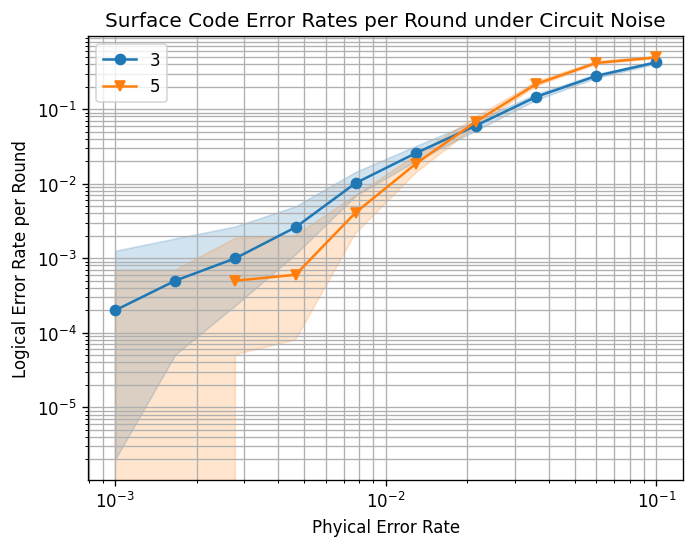

In [26]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_surface_code_stats,
    x_func=lambda stat: stat.json_metadata['p'],
    group_func=lambda stat: stat.json_metadata['d'],
    #failure_units_per_shot_func=lambda stat: stat.json_metadata['r'],
)
# ax.set_ylim(5e-3, 5e-2)
# ax.set_xlim(0.008, 0.012)
ax.loglog()
ax.set_title("Surface Code Error Rates per Round under Circuit Noise")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

## threshold

[[Model]]
    Model(decay2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 93
    # data points      = 20
    # variables        = 3
    chi-square         = 0.13252798
    reduced chi-square = 0.00779576
    Akaike info crit   = -94.3338751
    Bayesian info crit = -91.3466783
    R-squared          = 0.98781681
[[Variables]]
    a:  0.09476636 +/- 0.03427016 (36.16%) (init = 0.1)
    b:  0.03215779 +/- 0.07716852 (239.97%) (init = 0)
    p:  0.32486916 +/- 0.03663573 (11.28%) (init = 0.04)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, p) = +0.9972
    C(a, b) = +0.9220
    C(b, p) = +0.8978
[[Model]]
    Model(decay2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 47
    # data points      = 20
    # variables        = 3
    chi-square         = 0.27335179
    reduced chi-square = 0.01607952
    Akaike info crit   = -79.8545596
    Bayesian info crit = -76.8673627
    R-squared          = 0.98503210
[[Varia

c:\Users\diyan\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


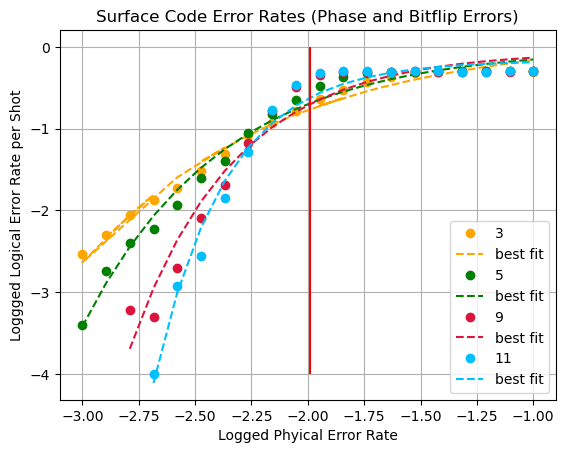

In [180]:
err_list_size = 20
d_list_size = 4

err_list = np.logspace(-3,-1, err_list_size)

a_list = np.logspace(-1,-4, err_list_size)

p_list = np.linspace(0.04,0.04, err_list_size)
guess_intervals = [(-2.25,-1.7), (-1.2, -0.7)]

log_threshold = log_find_exact_threshold(collected_surface_code_stats, 
                     err_list, 
                     err_list_size, 
                     d_list_size, 
                     False, 
                     a_list, 
                     p_list,
                     guess_intervals,
                     show_fit_report= True)



log_err_rate 0.005000000000000000104083408558608425664715468883514404296875
log_err_rate 0.01340000000000000045241588253475129022262990474700927734375
log_err_rate 0.00880000000000000053013149425851224805228412151336669921875
log_err_rate 0.00289999999999999980015985556747182272374629974365234375
log_err_rate 0.018700000000000001343369859796439413912594318389892578125
log_err_rate 0.049099999999999997812860641488441615365445613861083984375
log_err_rate 0.0303999999999999999389377336456163902767002582550048828125
log_err_rate 0.08269999999999999573674358543939888477325439453125
log_err_rate 0.11659999999999999531485883608183939941227436065673828125
log_err_rate 0.1630999999999999949817919286942924372851848602294921875
log_err_rate 0.2965999999999999747757328805164434015750885009765625
log_err_rate 0.2321999999999999897415392524635535664856433868408203125
log_err_rate 0.369300000000000017141843500212416984140872955322265625
log_err_rate 0.4341999999999999748645507224864559248089790344238

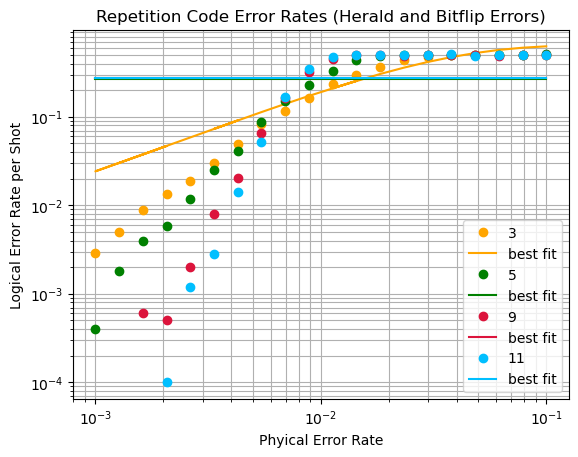

TypeError: 'float' object is not subscriptable

In [181]:
threshold = find_exact_threshold(collected_surface_code_stats, 
                     err_list, 
                     err_list_size, 
                     d_list_size, 
                     False, 
                     a_list, 
                     p_list)

# Both surface code threholds

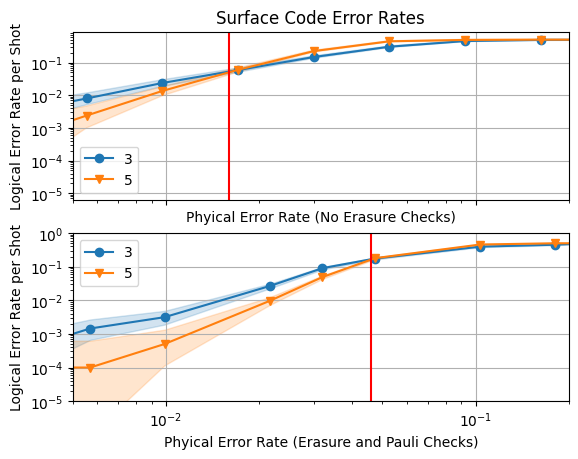

In [37]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)

e_and_p_stats_2 = sinter.stats_from_csv_files('e_and_p_2_two_circ_method.csv')
surf_without_e = sinter.stats_from_csv_files('surface_without_e.csv')

# Render a matplotlib plot of the data.



# fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax1,
    stats=surf_without_e,
    x_func=lambda stat: (18/10)*(stat.json_metadata['p']),
    group_func=lambda stat: stat.json_metadata['d'],
    #failure_units_per_shot_func=lambda stat: stat.json_metadata['r'],
)


sinter.plot_error_rate(
    ax=ax2,
    stats=e_and_p_stats_2,
    x_func=lambda stats: (18/10)* stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)


plt.xlim(5e-3, 2e-1)

ax1.loglog()
ax1.set_title("Surface Code Error Rates")
ax1.set_xlabel("Phyical Error Rate (No Erasure Checks)")
ax1.set_ylabel("Logical Error Rate per Shot")
ax1.grid(which='major')
ax2.set_ylim((1e-5,1))
ax1.legend()
ax1.vlines(1.6e-2, 1e-6, 1, "red")

ax2.loglog()
ax2.set_xlabel("Phyical Error Rate (Erasure and Pauli Checks)")
ax2.set_ylabel("Logical Error Rate per Shot")
ax2.grid(which='major')
ax2.set_ylim((1e-5,1))
ax2.legend()
ax2.vlines(4.6e-2, 1e-6, 1, "red")


In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(2, sharex=True)

e_and_p_stats_more_shots = sinter.stats_from_csv_files('e_and_p_more_shots.csv')
e_and_p_stats_higher_e_frac = sinter.stats_from_csv_files('e_and_p_higher_e_fraction.csv')
surf_without_e = sinter.stats_from_csv_files('surface_without_e.csv')

# Render a matplotlib plot of the data.



# fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax1,
    stats=surf_without_e,
    x_func=lambda stat: (18/10)*(stat.json_metadata['p']),
    group_func=lambda stat: stat.json_metadata['d'],
    #failure_units_per_shot_func=lambda stat: stat.json_metadata['r'],
)


sinter.plot_error_rate(
    ax=ax2,
    stats=e_and_p_stats_more_shots,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)

sinter.plot_error_rate(
    ax=ax3,
    stats=e_and_p_stats_higher_e_frac,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)


plt.xlim(5e-3, 2e-1)

ax1.loglog()
ax1.set_title("Surface Code Error Rates")
ax1.set_xlabel("Phyical Error Rate (No Erasure Checks)")
ax1.set_ylabel("Logical Error Rate per Shot")
ax1.grid(which='major')
ax2.set_ylim((1e-5,1))
ax1.legend()
ax1.vlines(1.6e-2, 1e-6, 1, "red")

ax2.loglog()
ax2.set_xlabel("Phyical Error Rate (0.55 Erasure)")
ax2.set_ylabel("Logical Error Rate per Shot")
ax2.grid(which='major')
ax2.set_ylim((1e-5,1))
ax2.legend()
ax2.vlines(4.6e-2, 1e-6, 1, "red")

ax2.loglog()
ax2.set_xlabel("Phyical Error Rate (0.7 Erasure)")
ax2.set_ylabel("Logical Error Rate per Shot")
ax2.grid(which='major')
ax2.set_ylim((1e-5,1))
ax2.legend()
ax2.vlines(4.6e-2, 1e-6, 1, "red")


# Both lambdas

mean [np.float64(0.0055811622125493485), np.float64(0.0034545556657439116), np.float64(0.002027649942472607)]
[[Model]]
    Model(lb)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 32
    # data points      = 3
    # variables        = 2
    chi-square         = 4.6211e-09
    reduced chi-square = 4.6211e-09
    Akaike info crit   = -56.8737056
    Bayesian info crit = -58.6764810
    R-squared          = 0.99927742
[[Variables]]
    l:  0.60811450 +/- 0.00921741 (1.52%) (init = 0.5)
    a:  0.01513428 +/- 5.7654e-04 (3.81%) (init = 0.001)
[[Correlations]] (unreported correlations are < 0.100)
    C(l, a) = -0.9657
[[Model]]
    Model(lb)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 99
    # data points      = 3
    # variables        = 2
    chi-square         = 4.9178e-11
    reduced chi-square = 4.9178e-11
    Akaike info crit   = -70.5025479
    Bayesian info crit = -72.3053233
    R-squared          = 0.99963665
[[Varia

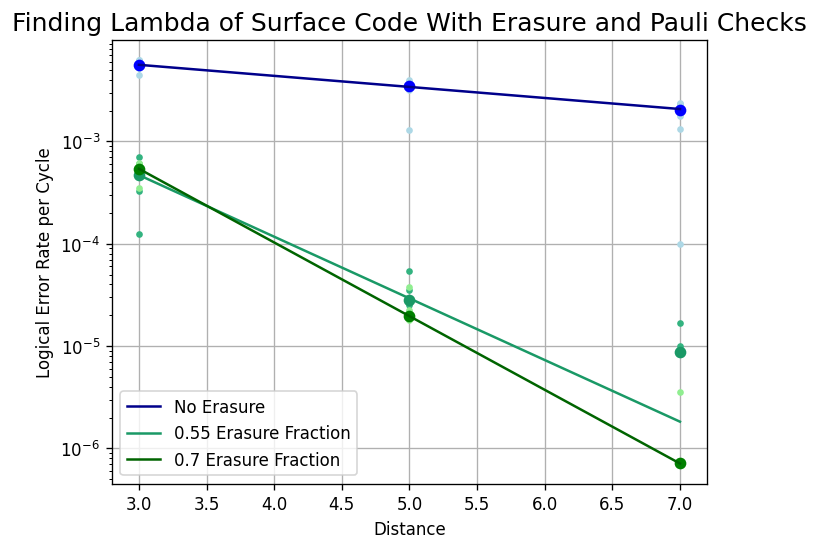

In [3]:
e_and_p_lambda = sinter.stats_from_csv_files('e_and_p_lambda.csv')
e_and_p_seventy_lambda = sinter.stats_from_csv_files('e_and_p_seventy_lambda.csv')
no_e_lambda = sinter.stats_from_csv_files("lambda_unherald_surface.csv")


def lb(d, l,a):
    y = a*l**(((d+1)/2)) 
    return y


fig, ax = plt.subplots(1, 1)


### NO E####


xs_no_e = [(stat.json_metadata['d']) for stat in no_e_lambda]
ys_no_e = [(stat.errors/stat.shots/stat.json_metadata['r']) for stat in no_e_lambda]




group_func=lambda stats: stats.json_metadata['d']
grouped_stats = sinter.group_by(no_e_lambda, key = group_func)

mean_y_list = []
group_y_list = []
for d in grouped_stats:
    grouped_ys = [(stat.errors/stat.shots/stat.json_metadata['r']) for stat in grouped_stats[d]]
    group_y_list.append(grouped_ys)
    mean_y_list.append(np.mean(grouped_ys))

print('mean', mean_y_list)

plt.plot(xs_no_e,ys_no_e, ".", color = "lightblue")
plt.plot(grouped_stats.keys() , mean_y_list, "o", color = "blue")


lb_model = Model(lb)
# lb_model.set_param_hint('a', min=0.5, max = 10)
params = lb_model.make_params()

result_no_e = lb_model.fit(mean_y_list, 
                                 d=list(grouped_stats.keys() ), 
                                 l = 0.5,
                                 a = 0.001
                                 )



print(result_no_e.fit_report())

plt.plot(grouped_stats.keys(), result_no_e.best_fit, '-', label='No Erasure', color = "darkblue")




l = result_no_e.best_values['l']
a = result_no_e.best_values['a']

d_3_no_e = lb(3, l, a)
d_5_no_e = lb(5, l, a)
d_7_no_e = lb(7, l, a)





#### E AND P ######

xs_ep = [(stat.json_metadata['d']) for stat in e_and_p_lambda]
ys_ep = [(stat.errors/stat.shots/stat.json_metadata['r']) for stat in e_and_p_lambda]


group_func=lambda stats: stats.json_metadata['d']
grouped_stats = sinter.group_by(e_and_p_lambda, key = group_func)

mean_y_list = []
group_y_list = []
for d in grouped_stats:
    grouped_ys = [(stat.errors/stat.shots/stat.json_metadata['r']) for stat in grouped_stats[d]]
    group_y_list.append(grouped_ys)
    mean_y_list.append(np.mean(grouped_ys))


plt.plot(xs_ep,ys_ep, ".", color = (0.2, 0.7, 0.5, 1))
plt.plot(grouped_stats.keys() , mean_y_list, "o", color = (0.1, 0.6, 0.4, 1))


lb_model = Model(lb)
# lb_model.set_param_hint('a', min=0.5, max = 10)
params = lb_model.make_params()

result_ep = lb_model.fit(mean_y_list, 
                                 d=list(grouped_stats.keys() ), 
                                 l = 0.5,
                                 a = 0.001
                                 )


print(result_ep.fit_report())


#plt.plot(grouped_stats.keys(), result.init_fit, '--', label='initial fit')
plt.plot(grouped_stats.keys(), result_ep.best_fit, '-', label='0.55 Erasure Fraction',color = (0.1, 0.6, 0.4, 1))



l = result_ep.best_values['l']
a = result_ep.best_values['a']

d_3 = lb(3, l, a)
d_5 = lb(5, l, a)
d_7 = lb(7, l, a)




print(d_3_no_e/d_5_no_e)
print(d_5_no_e/d_7_no_e)

print(d_3/d_5)
print(d_5/d_7)


#### 70 % E AND P ######

xs_ep_70 = [(stat.json_metadata['d']) for stat in e_and_p_seventy_lambda]
ys_ep_70 = [(stat.errors/stat.shots/stat.json_metadata['r']) for stat in e_and_p_seventy_lambda]


group_func=lambda stats: stats.json_metadata['d']
grouped_stats = sinter.group_by(e_and_p_seventy_lambda, key = group_func)

mean_y_list = []
group_y_list = []
for d in grouped_stats:
    grouped_ys = [(stat.errors/stat.shots/stat.json_metadata['r']) for stat in grouped_stats[d]]
    group_y_list.append(grouped_ys)
    mean_y_list.append(np.mean(grouped_ys))


plt.plot(xs_ep_70,ys_ep_70, ".", color = "lightgreen")
plt.plot(grouped_stats.keys() , mean_y_list, "o",  color = "green")


lb_model = Model(lb)
# lb_model.set_param_hint('a', min=0.5, max = 10)
params = lb_model.make_params()

result_ep_70 = lb_model.fit(mean_y_list, 
                                 d=list(grouped_stats.keys() ), 
                                 l = 0.5,
                                 a = 0.0001
                                 )


print(result_ep_70.fit_report())


#plt.plot(grouped_stats.keys(), result.init_fit, '--', label='initial fit')
plt.plot(grouped_stats.keys(), result_ep_70.best_fit, '-', label='0.7 Erasure Fraction', color = "darkgreen")


l = result_ep_70.best_values['l']
a = result_ep_70.best_values['a']

d_3_70 = lb(3, l, a)
d_5_70 = lb(5, l, a)
d_7_70 = lb(7, l, a)




print(d_3_no_e/d_5_no_e)
print(d_5_no_e/d_7_no_e)

print(d_3/d_5)
print(d_5/d_7)



print(f"Lambda of non-erasure surface code is {np.mean([d_3_no_e/d_5_no_e, d_5_no_e/d_7_no_e])}")
print(f"Lambda of 55% erasure surface code is {np.mean([d_3/d_5, d_5/d_7])}")
print(f"Lambda of 70% erasure surface code is {np.mean([d_3_70/d_5_70, d_5_70/d_7_70])}")

ax.set_yscale('log')
plt.rc('axes', titlesize = 15)
plt.rc('axes', labelsize = 15)
plt.xlabel("Distance")
plt.ylabel("Logical Error Rate per Cycle")
ax.grid(which='major')
# ax.grid(which='minor')
plt.title("Finding Lambda of Surface Code With Erasure and Pauli Checks")
plt.legend()
fig.set_dpi(120) 

print(mean_y_list)
print(np.mean([mean_y_list[0]/mean_y_list[1], mean_y_list[1]/mean_y_list[2]]))

